# ML-ImmuneProfiler

## Single-Cell RNA-seq Cell Type Classification: Notebook 4

### Support Vector Machines (SVM) Classifier

- Date: 2025-04-17


This notebook implements and analyzes Support Vector Machine (SVM) classifiers for cell type classification based on single-cell RNA-sequencing data. SVMs are particularly suitable for this high-dimensional genomic data classification task due to their effectiveness with complex decision boundaries and robustness against overfitting.

## Overview

In this notebook, we:

1. **Load and verify the preprocessed dataset** split into training, validation, and test sets
2. **Implement a CUDA Based GPU-accelerated SVM classifier** using cuML for improved performance
3. **Perform hyperparameter tuning** to optimize the SVM's performance
4. **Analyze model performance** using multiple metrics and visualizations
5. **Visualize classification results** with UMAP dimension reduction
6. **Evaluate feature importance** to identify the most influential genes
7. **Test the final model** on held-out test data

## Technical Approach

- We implement an RBF kernel SVM with balanced class weights to handle the inherent class imbalance in scRNA-seq data
- Hyperparameter search focuses on tuning the regularization parameter (C) and kernel coefficient (gamma)
- GPU acceleration via cuML provides significant speedup for training and inference
- Detailed performance analysis includes confusion matrices, ROC curves, precision-recall curves, and UMAP visualizations

## Key Metrics

The model is evaluated using:
- Accuracy and balanced accuracy
- F1 score (macro and weighted)
- Precision and recall
- ROC-AUC score
- Per-class performance metrics

We also analyze misclassification patterns and prediction confidence to gain deeper insights into model behavior.

In [2]:
import os
import time
import pickle
import joblib
from itertools import cycle
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from cupyx.profiler import benchmark
from cuml.svm import SVC as cuSVC

from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    precision_recall_curve, roc_curve, roc_auc_score, auc,
    f1_score, precision_score, recall_score, balanced_accuracy_score
)
import time
import numpy as np
from cuml.svm import SVC
from cuml.metrics import accuracy_score
import cupy as cp
from sklearn.metrics import balanced_accuracy_score, f1_score, precision_score, recall_score
    
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import GridSearchCV, learning_curve


In [3]:
# Global Variables
RAND_SEED: int = 16         # it's my birthday :)
cp.random.seed(RAND_SEED)

DATA_DIR: str = os.path.join(os.path.dirname(os.getcwd()), 'Data')
RESULTS_DIR: str = os.path.join(os.path.dirname(os.getcwd()), 'Results')
PLOT_DIR: str = os.path.join(os.path.dirname(os.getcwd()), 'Plots')
MODEL_DIR: str = os.path.join(os.path.dirname(os.getcwd()), 'Models')
# Create directories if they do not exist
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(PLOT_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

In [4]:
# load the dataset
spv_dataset = joblib.load(os.path.join(DATA_DIR, 'spv_split_dataset_100hvg.pkl'))

# verify the integrity of cell types in test, train and validation sets
def verify_cell_types_integrity(spv_dataset):
    """
    Verify the integrity of cell types in the train, validation, and test sets.
    """
    print("Verifying cell types integrity...")
    
    # Check unique classes in each split
    for split in ['train', 'val', 'test']:
        y_split = spv_dataset[f'y_{split}']
        unique_classes = np.unique(y_split)
        print(f"Unique classes in {split} set: {unique_classes}")
    
    # Check for common classes across all splits
    train_classes = set(np.unique(spv_dataset['y_train']))
    val_classes = set(np.unique(spv_dataset['y_val']))
    test_classes = set(np.unique(spv_dataset['y_test']))
    
    common_classes = train_classes.intersection(val_classes, test_classes)
    print(f"Common classes across all splits: {sorted(list(common_classes))}")
    
    # Check class distributions
    label_encoder = spv_dataset['label_encoder']
    class_names = label_encoder.classes_
    
    print("\nClass distribution ratios (% of total):")
    print(f"{'Class':<15} {'Train %':<10} {'Val %':<10} {'Test %':<10} {'Total %':<10}")
    print("-" * 55)
    
    total_train = len(spv_dataset['y_train'])
    total_val = len(spv_dataset['y_val'])
    total_test = len(spv_dataset['y_test'])
    total_all = total_train + total_val + total_test
    
    for i, class_name in enumerate(class_names):
        train_count = np.sum(spv_dataset['y_train'] == i)
        val_count = np.sum(spv_dataset['y_val'] == i)
        test_count = np.sum(spv_dataset['y_test'] == i)
        total_count = train_count + val_count + test_count
        
        train_ratio = train_count / total_train * 100
        val_ratio = val_count / total_val * 100
        test_ratio = test_count / total_test * 100
        total_ratio = total_count / total_all * 100
        
        print(f"{class_name:<15} {train_ratio:>8.2f}% {val_ratio:>8.2f}% {test_ratio:>8.2f}% {total_ratio:>8.2f}%")
    
    # Check dataset split ratios
    print("\nDataset split ratios:")
    print(f"Train: {total_train / total_all * 100:.2f}% ({total_train} samples)")
    print(f"Val:   {total_val / total_all * 100:.2f}% ({total_val} samples)")
    print(f"Test:  {total_test / total_all * 100:.2f}% ({total_test} samples)")
    
    # Check for potential cross-validation issues
    print("\nPotential CV issues assessment:")
    
    # Check if any classes are missing from any split
    if len(train_classes) != len(class_names) or len(val_classes) != len(class_names) or len(test_classes) != len(class_names):
        print("Warning: Some classes are missing from one or more splits!")
        print(f"Missing from train: {sorted(list(set(range(len(class_names))) - train_classes))}")
        print(f"Missing from val: {sorted(list(set(range(len(class_names))) - val_classes))}")
        print(f"Missing from test: {sorted(list(set(range(len(class_names))) - test_classes))}")
    else:
        print("✓ All classes are represented in each split")
    
    # Check for severe class imbalance
    class_balance_issues = []
    for i, class_name in enumerate(class_names):
        train_count = np.sum(spv_dataset['y_train'] == i)
        val_count = np.sum(spv_dataset['y_val'] == i)
        test_count = np.sum(spv_dataset['y_test'] == i)
        
        if train_count < 5 or val_count < 5 or test_count < 5:
            class_balance_issues.append(f"{class_name} (train={train_count}, val={val_count}, test={test_count})")
    
    if class_balance_issues:
        print("Warning: Some classes have very few samples in some splits:")
        for issue in class_balance_issues:
            print(f"  - {issue}")
    else:
        print("✓ All classes have sufficient samples in each split")
    
    # Check split ratios per class
    print("\nSplit ratios per class:")
    print(f"{'Class':<15} {'Train %':<10} {'Val %':<10} {'Test %':<10}")
    print("-" * 45)
    
    for i, class_name in enumerate(class_names):
        train_count = np.sum(spv_dataset['y_train'] == i)
        val_count = np.sum(spv_dataset['y_val'] == i)
        test_count = np.sum(spv_dataset['y_test'] == i)
        class_total = train_count + val_count + test_count
        
        class_train_ratio = train_count / class_total * 100
        class_val_ratio = val_count / class_total * 100
        class_test_ratio = test_count / class_total * 100
        
        print(f"{class_name:<15} {class_train_ratio:>8.2f}% {class_val_ratio:>8.2f}% {class_test_ratio:>8.2f}%")
    
    print("\nIntegrity verification complete!")

verify_cell_types_integrity(spv_dataset)

Verifying cell types integrity...
Unique classes in train set: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Unique classes in val set: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Unique classes in test set: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Common classes across all splits: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

Class distribution ratios (% of total):
Class           Train %    Val %      Test %     Total %   
-------------------------------------------------------
B intermediate      4.53%     4.53%     4.53%     4.53%
B memory            2.85%     2.85%     2.85%     2.85%
B naive             9.96%     9.95%     9.95%     9.96%
CD14 Mono          12.58%    12.57%    12.58%    12.58%
CD16 Mono           8.26%     8.26%     8.26%     8.26%
CD4 Naive           9.25%     9.25%     9.25%     9.25%
CD4 TCM            12.03%    12.03%    12.03%    12.03%
CD4 TEM             1.74%     1.73%     1.73%     1.74%
CD8 Naive          11.80%    11.80%    11.80%    11.80%
CD8 TCM 

In [5]:
# Dataset extract components
X_train = spv_dataset['X_train']
X_val = spv_dataset['X_val']
X_test = spv_dataset['X_test']
y_train = spv_dataset['y_train']
y_val = spv_dataset['y_val']
y_test = spv_dataset['y_test']
meta_train = spv_dataset['meta_train']
meta_val = spv_dataset['meta_val']
meta_test = spv_dataset['meta_test']
label_encoder = spv_dataset['label_encoder']
class_weights = spv_dataset['class_weights']
feature_genes = spv_dataset['feature_genes']

# Display dataset shapes with more formatting
print("Dataset Shapes:")
print(f"X_train: {X_train.shape} samples x {X_train.shape[1]} features")
print(f"X_val:   {X_val.shape} samples x {X_val.shape[1]} features")
print(f"X_test:  {X_test.shape} samples x {X_test.shape[1]} features")
print(f"y_train: {y_train.shape}")
print(f"y_val:   {y_val.shape}")
print(f"y_test:  {y_test.shape}")

# Display class information 
print("\nClass Names and Encodings:")
classes = label_encoder.classes_
for i, class_name in enumerate(classes):
    count_train = np.sum(y_train == i)
    count_val = np.sum(y_val == i)
    count_test = np.sum(y_test == i)
    total_count = count_train + count_val + count_test
    weight = class_weights.get(i, "N/A")
    print(f"Class {i:<2} = {class_name:<15} | Train: {count_train:<5} | Val: {count_val:<5} | Test: {count_test:<5} | Total: {total_count:<5} | Weight: {weight}")

# Display feature gene statistics
print(f"\nFeature Genes: {len(feature_genes)} genes")
print(f"First 10 genes: {feature_genes[:10]}")
print(f"Last 10 genes: {feature_genes[-10:]}")

# Check for NaN values
print("\nData Quality Check:")
nan_train = np.isnan(X_train).sum()
nan_val = np.isnan(X_val).sum()
nan_test = np.isnan(X_test).sum()

if np.any(nan_train):
    print(f"Warning: Found {nan_train} NaN values in X_train")
    print(f"NaN distribution per feature: {np.isnan(X_train).sum(axis=0)[np.isnan(X_train).sum(axis=0) > 0]}")
else:
    print("✓ X_train: No NaN values detected")
    
if np.any(nan_val):
    print(f"Warning: Found {nan_val} NaN values in X_val")
    print(f"NaN distribution per feature: {np.isnan(X_val).sum(axis=0)[np.isnan(X_val).sum(axis=0) > 0]}")
else:
    print("✓ X_val: No NaN values detected")
    
if np.any(nan_test):
    print(f"Warning: Found {nan_test} NaN values in X_test")
    print(f"NaN distribution per feature: {np.isnan(X_test).sum(axis=0)[np.isnan(X_test).sum(axis=0) > 0]}")
else:
    print("✓ X_test: No NaN values detected")

# Check data types
print(f"\nData Types:")
print(f"X_train dtype: {X_train.dtypes.unique()}")
print(f"y_train dtype: {y_train.dtype}")

Dataset Shapes:
X_train: (53825, 100) samples x 100 features
X_val:   (11534, 100) samples x 100 features
X_test:  (11534, 100) samples x 100 features
y_train: (53825,)
y_val:   (11534,)
y_test:  (11534,)

Class Names and Encodings:
Class 0  = B intermediate  | Train: 2438  | Val: 523   | Test: 522   | Total: 3483  | Weight: 1.5769658971053557
Class 1  = B memory        | Train: 1535  | Val: 329   | Test: 329   | Total: 2193  | Weight: 2.504653327128897
Class 2  = B naive         | Train: 5360  | Val: 1148  | Test: 1148  | Total: 7656  | Weight: 0.7172841151385928
Class 3  = CD14 Mono       | Train: 6769  | Val: 1450  | Test: 1451  | Total: 9670  | Weight: 0.567977966781335
Class 4  = CD16 Mono       | Train: 4445  | Val: 953   | Test: 953   | Total: 6351  | Weight: 0.8649365257914189
Class 5  = CD4 Naive       | Train: 4980  | Val: 1067  | Test: 1067  | Total: 7114  | Weight: 0.7720166379804934
Class 6  = CD4 TCM         | Train: 6475  | Val: 1387  | Test: 1388  | Total: 9250  | Weigh

## SVM Classifier Implementation

Main training and evaluation loop for the SVM classifier. This includes data loading, model training, hyperparameter tuning, and performance evaluation. 

Uses a manual grid search for hyperparameter tuning, as cuML does not currently support `GridSearchCV` directly. The code is structured to allow easy modification for different datasets or hyperparameters.

Also uses cuPy for GPU-accelerated data handling and manipulation, ensuring that the entire pipeline is optimized for performance. (similar syntax to NumPy, but with GPU support)

In [7]:
def train_cuml_svc(X_train, y_train, X_val, y_val, random_seed=16):
    """
    Train cuML SVC classifier with RBF kernel and perform hyperparameter tuning.
    Uses 'balanced' class weights for handling class imbalance.
    
    Parameters:
    -----------
    X_train, y_train: Training data and labels
    X_val, y_val: Validation data and labels
    random_seed: Random seed for reproducibility
    
    Returns:
    --------
    best_model: Trained cuML SVC model with best parameters
    best_params: Best parameters found during hyperparameter tuning
    val_accuracy: Validation accuracy of the best model
    inverse_mapping: Mapping to convert predictions back to original labels
    """

    # Get and print GPU information
    print("\n=== GPU Information ===")
    gpu_details = cp.cuda.runtime.getDeviceProperties(cp.cuda.runtime.getDevice())
    print(f"GPU Device: {gpu_details['name'].decode()}")
    print(f"Compute Capability: {gpu_details['major']}.{gpu_details['minor']}")
    print(f"Total Memory: {gpu_details['totalGlobalMem'] / (1024**3):.2f} GB")
    
    # Now continue with the original function
    print("\nStarting cuML SVC classifier training with RBF kernel...")
    total_start_time = time.time()
    
    # Convert data to CuPy arrays efficiently
    # Use a single stream for all transfers to avoid synchronization overhead
    with cp.cuda.Stream(non_blocking=True) as stream:
        # Convert feature matrices
        X_train_gpu = cp.asarray(X_train) if not isinstance(X_train, cp.ndarray) else X_train
        X_val_gpu = cp.asarray(X_val) if not isinstance(X_val, cp.ndarray) else X_val
        
        # For labels, convert to numpy first if needed for consistent handling
        y_train_np = cp.asnumpy(y_train) if isinstance(y_train, cp.ndarray) else np.asarray(y_train)
        y_val_np = cp.asnumpy(y_val) if isinstance(y_val, cp.ndarray) else np.asarray(y_val)
        
        # Create label mapping (original label -> integer index)
        unique_original_labels = np.unique(y_train_np)
        label_mapping = {lbl: i for i, lbl in enumerate(unique_original_labels)}
        inverse_mapping = {i: lbl for lbl, i in label_mapping.items()}
        
        # Check if labels already match their indices (e.g., 0, 1, 2...)
        labels_already_indices = all(i == lbl for i, lbl in enumerate(unique_original_labels))
        
        # If labels are already 0, 1, 2... then no mapping needed
        if labels_already_indices:
            y_train_gpu = cp.asarray(y_train_np)
            y_val_gpu = cp.asarray(y_val_np)
            y_val_cpu = y_val_np.copy()
        else:
            # Apply mapping and transfer to GPU
            y_train_mapped = np.array([label_mapping[lbl] for lbl in y_train_np])
            y_val_mapped = np.array([label_mapping[lbl] for lbl in y_val_np])
            
            y_train_gpu = cp.asarray(y_train_mapped)
            y_val_gpu = cp.asarray(y_val_mapped)
            
            # Keep a CPU version of validation labels for metrics calculation
            y_val_cpu = y_val_mapped.copy()
        
        # Synchronize after all transfers
        stream.synchronize()
    
    # Display class distribution information
    print("\nClass distribution in training set:")
    unique_mapped_classes = cp.unique(y_train_gpu).get()
    class_counts = {cls: cp.sum(y_train_gpu == cls).item() for cls in unique_mapped_classes}
    
    # Calculate balanced weights for display purposes only
    total_samples = len(y_train_gpu)
    n_classes = len(unique_mapped_classes)
    balanced_weights = {cls: total_samples / (n_classes * count) for cls, count in class_counts.items()}
    
    for cls, count in class_counts.items():
        orig_cls = inverse_mapping.get(cls, cls)  # Use the original label if available
        percentage = count / total_samples * 100
        bal_weight = balanced_weights[cls]
        print(f"Class {cls:<2} (original: {orig_cls}) = {count:<5} samples ({percentage:>5.2f}%) | Balanced Weight: {bal_weight:.4f}")
    
    # Define parameter combinations for hyperparameter tuning
    c_values = [0.1, 1, 10]
    gamma_values = ['scale', 'auto']
    
    # Display hyperparameter search space
    print("\nHyperparameter search space:")
    print(f"C: {c_values}")
    print(f"gamma: {gamma_values}")
    print(f"class_weight: balanced (fixed)")
    
    # Calculate total combinations
    total_combinations = len(c_values) * len(gamma_values)
    print(f"\nTotal parameter combinations to evaluate: {total_combinations}")
    
    # Prepare for hyperparameter search
    best_score = -1
    best_params = {}
    best_model = None
    results = []
    
    # Perform hyperparameter search
    print("\nPerforming hyperparameter search...")
    combination_count = 0
    
    # Iterate through C values with tqdm for progress tracking
    for c_idx, c in enumerate(tqdm(c_values)):
        for gamma_idx, gamma in enumerate(gamma_values):
            combination_count += 1
            print(f"\nEvaluating combination {combination_count}/{total_combinations}:")
            print(f"C={c}, gamma={gamma}, class_weight=balanced")
            
            # Train model with current parameters
            model = SVC(
                C=c,
                kernel='rbf',
                gamma=gamma,
                class_weight='balanced',
                probability=True,
                random_state=random_seed,
                verbose=False
            )
            
            # Train model with error handling
            try:
                fit_start_time = time.time()
                model.fit(X_train_gpu, y_train_gpu)
                fit_time = time.time() - fit_start_time
                print(f"Training completed in {fit_time:.2f} seconds")
                
                # Evaluate on validation set
                val_eval_start = time.time()
                y_val_pred_gpu = model.predict(X_val_gpu)
                val_eval_time = time.time() - val_eval_start
                
                # Convert predictions to CPU for metrics
                y_val_pred = cp.asnumpy(y_val_pred_gpu) if isinstance(y_val_pred_gpu, cp.ndarray) else y_val_pred_gpu
                
                # Calculate metrics
                val_accuracy = accuracy_score(y_val_cpu, y_val_pred)
                val_balanced_accuracy = balanced_accuracy_score(y_val_cpu, y_val_pred)
                
                print(f"Validation Accuracy: {val_accuracy:.4f}")
                print(f"Validation Balanced Accuracy: {val_balanced_accuracy:.4f}")
                
                # Store results
                results.append({
                    'C': c,
                    'gamma': gamma,
                    'accuracy': val_accuracy,
                    'balanced_accuracy': val_balanced_accuracy,
                    'training_time': fit_time
                })
                
                # Update best model if current is better
                if val_balanced_accuracy > best_score:
                    best_score = val_balanced_accuracy
                    best_model = model
                    best_params = {
                        'C': c, 
                        'gamma': gamma
                    }
            except Exception as e:
                print(f"Error training model with these parameters: {e}")
                continue
    
    # Check if we found any valid model
    if best_model is None:
        print("\nNo valid model was found. All training attempts failed.")
        # Return default values
        return None, {}, 0.0, inverse_mapping
    
    # Get final predictions with best model
    y_val_pred = cp.asnumpy(best_model.predict(X_val_gpu)) if isinstance(X_val_gpu, cp.ndarray) else best_model.predict(X_val_gpu)
    
    # Calculate final metrics
    val_accuracy = accuracy_score(y_val_cpu, y_val_pred)
    val_balanced_accuracy = balanced_accuracy_score(y_val_cpu, y_val_pred)
    val_f1_macro = f1_score(y_val_cpu, y_val_pred, average='macro')
    val_precision = precision_score(y_val_cpu, y_val_pred, average='macro')
    val_recall = recall_score(y_val_cpu, y_val_pred, average='macro')
    
    # Print best results
    print("\nBest Parameters Found:")
    print(f"Best parameters: {best_params}")
    print(f"Best validation balanced accuracy: {best_score:.4f}")
    
    # Print validation results with best model
    print("\nValidation Performance (Best Model):")
    print(f"Accuracy: {val_accuracy:.4f}")
    print(f"Balanced Accuracy: {val_balanced_accuracy:.4f}")
    print(f"Macro F1 Score: {val_f1_macro:.4f}")
    print(f"Macro Precision: {val_precision:.4f}")
    print(f"Macro Recall: {val_recall:.4f}")
    
    # Calculate and print confusion matrix
    conf_matrix = confusion_matrix(y_val_cpu, y_val_pred)
    print("\nConfusion Matrix:")
    print(conf_matrix)
    
    # Per-class metrics
    print("\nPer-Class Metrics:")
    for i in range(len(unique_mapped_classes)):
        orig_cls = inverse_mapping.get(i, i)  # Use the original label if available
        cls_precision = precision_score(y_val_cpu, y_val_pred, labels=[i], average=None)[0]
        cls_recall = recall_score(y_val_cpu, y_val_pred, labels=[i], average=None)[0]
        cls_f1 = f1_score(y_val_cpu, y_val_pred, labels=[i], average=None)[0]
        
        # Calculate samples per class in validation set
        val_count = np.sum(y_val_cpu == i)
        val_percent = val_count / len(y_val_cpu) * 100
        
        # Calculate TP, FP, FN, TN
        tp = conf_matrix[i, i]
        fp = conf_matrix[:, i].sum() - tp
        fn = conf_matrix[i, :].sum() - tp
        tn = conf_matrix.sum() - (tp + fp + fn)
        
        print(f"Class {i} (original: {orig_cls}):")
        print(f"  Samples: {val_count} ({val_percent:.2f}% of validation set)")
        print(f"  Precision: {cls_precision:.4f}")
        print(f"  Recall: {cls_recall:.4f}")
        print(f"  F1-Score: {cls_f1:.4f}")
        print(f"  True Positives: {tp}, False Positives: {fp}")
        print(f"  False Negatives: {fn}, True Negatives: {tn}")
    
    # ROC-AUC score (if probability is enabled)
    try:
        # Get probability predictions
        y_val_proba = best_model.predict_proba(X_val_gpu)
        if isinstance(y_val_proba, cp.ndarray):
            y_val_proba = cp.asnumpy(y_val_proba)
        
        # Calculate ROC-AUC score
        if len(unique_mapped_classes) > 2:
            # Multi-class
            roc_auc = roc_auc_score(y_val_cpu, y_val_proba, multi_class='ovr', average='macro')
            print(f"\nROC-AUC Score (One-vs-Rest): {roc_auc:.4f}")
        else:
            # Binary classification
            roc_auc = roc_auc_score(y_val_cpu, y_val_proba[:, 1])
            print(f"\nROC-AUC Score: {roc_auc:.4f}")
    except Exception as e:
        print(f"\nCould not calculate ROC-AUC score: {e}")
    
    # Print support vectors information if available
    try:
        support_indices = best_model.support_
        n_support = best_model.n_support_
        total_support_vectors = cp.sum(n_support).item() if isinstance(n_support, cp.ndarray) else sum(n_support)
        
        print(f"\nSupport Vector Analysis:")
        print(f"Total support vectors: {total_support_vectors} ({total_support_vectors/len(X_train_gpu)*100:.2f}% of training data)")
        
        for i, count in enumerate(n_support):
            count_val = count.item() if isinstance(count, cp.ndarray) else count
            class_samples = class_counts.get(i, 0)
            percentage = count_val / class_samples * 100 if class_samples > 0 else 0
            print(f"Class {i} (original: {inverse_mapping.get(i, i)}): {count_val} support vectors ({percentage:.2f}% of class samples)")
    except (AttributeError, TypeError) as e:
        print(f"\nCould not access support vector information: {e}")
    
    # Print hyperparameter search summary (sorted by balanced accuracy)
    print("\nHyperparameter Search Summary (Top 10 combinations):")
    sorted_results = sorted(results, key=lambda x: x['balanced_accuracy'], reverse=True)
    print("Rank  C      gamma   Accuracy  Balanced Acc  Training Time")
    print("-" * 70)
    for i, res in enumerate(sorted_results[:10]):
        print(f"{i+1:<5} {res['C']:<6} {res['gamma']:<7} {res['accuracy']:.4f}    {res['balanced_accuracy']:.4f}       {res['training_time']:.2f}s")
    
    # Display total training time
    total_time = time.time() - total_start_time
    print(f"\nTotal training time: {total_time:.2f} seconds ({total_time/60:.2f} minutes)")
    
    # Print final model summary
    print("\nFinal Model Summary:")
    print(f"Best C value: {best_params['C']}")
    print(f"Best gamma value: {best_params['gamma']}")
    print(f"Class weight: balanced")
    print(f"Number of classes: {len(unique_mapped_classes)}")
    print(f"Training set size: {len(X_train_gpu)}")
    print(f"Validation set size: {len(X_val_gpu)}")
    
    # Model diagnostics
    prediction_ratio = {}
    unique_preds, counts = np.unique(y_val_pred, return_counts=True)
    for i, cls in enumerate(unique_preds):
        pred_count = counts[i]
        pred_percentage = pred_count / len(y_val_pred) * 100
        actual_count = np.sum(y_val_cpu == cls)
        prediction_ratio[inverse_mapping.get(cls, cls)] = pred_count / actual_count if actual_count > 0 else float('inf')
        print(f"Class {cls} (original: {inverse_mapping.get(cls, cls)}) predicted {pred_count} times ({pred_percentage:.2f}% of predictions)")
        print(f"  Actual count: {actual_count}, Prediction ratio: {prediction_ratio[inverse_mapping.get(cls, cls)]:.2f}")
        
    # Check for missing predictions
    missing_predictions = set(unique_mapped_classes) - set(unique_preds)
    if missing_predictions:
        print("\nWARNING: The following classes were never predicted:")
        for cls in missing_predictions:
            print(f"  Class {cls} (original: {inverse_mapping.get(cls, cls)})")
    
    # Free GPU memory
    del X_train_gpu, y_train_gpu, X_val_gpu
    cp.get_default_memory_pool().free_all_blocks()
    
    return best_model, best_params, val_accuracy, inverse_mapping

# Usage example:
best_model, best_params, val_accuracy, inverse_mapping = train_cuml_svc(
    X_train, y_train, X_val, y_val
)

if best_model is None:
    print("Training failed. No valid model was produced.")
else:
    print(f"Successfully trained model with accuracy: {val_accuracy:.4f}")


=== GPU Information ===
GPU Device: NVIDIA GeForce RTX 4070 Laptop GPU
Compute Capability: 8.9
Total Memory: 8.00 GB

Starting cuML SVC classifier training with RBF kernel...

Class distribution in training set:
Class 0  (original: 0) = 2438  samples ( 4.53%) | Balanced Weight: 1.5770
Class 1  (original: 1) = 1535  samples ( 2.85%) | Balanced Weight: 2.5047
Class 2  (original: 2) = 5360  samples ( 9.96%) | Balanced Weight: 0.7173
Class 3  (original: 3) = 6769  samples (12.58%) | Balanced Weight: 0.5680
Class 4  (original: 4) = 4445  samples ( 8.26%) | Balanced Weight: 0.8649
Class 5  (original: 5) = 4980  samples ( 9.25%) | Balanced Weight: 0.7720
Class 6  (original: 6) = 6475  samples (12.03%) | Balanced Weight: 0.5938
Class 7  (original: 7) = 935   samples ( 1.74%) | Balanced Weight: 4.1119
Class 8  (original: 8) = 6350  samples (11.80%) | Balanced Weight: 0.6055
Class 9  (original: 9) = 1680  samples ( 3.12%) | Balanced Weight: 2.2885
Class 10 (original: 10) = 6045  samples (11.23%

  0%|          | 0/3 [00:00<?, ?it/s]


Evaluating combination 1/6:
C=0.1, gamma=scale, class_weight=balanced
[W] [16:36:14.277065] Random state is currently ignored by probabilistic SVC
Training completed in 169.95 seconds
Validation Accuracy: 0.8249
Validation Balanced Accuracy: 0.7512

Evaluating combination 2/6:
C=0.1, gamma=auto, class_weight=balanced
[W] [16:39:36.897106] Random state is currently ignored by probabilistic SVC
Training completed in 428.61 seconds


 33%|███▎      | 1/3 [11:26<22:52, 686.25s/it]

Validation Accuracy: 0.8249
Validation Balanced Accuracy: 0.7522

Evaluating combination 3/6:
C=1, gamma=scale, class_weight=balanced
[W] [16:47:40.524640] Random state is currently ignored by probabilistic SVC
[W] [16:48:02.874418] Warning: could not fill working set, found only 1007 elements
[W] [16:48:37.762753] Warning: could not fill working set, found only 1008 elements
[W] [16:49:18.258168] Warning: could not fill working set, found only 1005 elements
[W] [16:50:07.679992] Warning: could not fill working set, found only 1006 elements
[W] [16:50:52.537367] Warning: could not fill working set, found only 1005 elements
Training completed in 213.80 seconds
Validation Accuracy: 0.8343
Validation Balanced Accuracy: 0.7995

Evaluating combination 4/6:
C=1, gamma=auto, class_weight=balanced
[W] [16:51:53.032763] Random state is currently ignored by probabilistic SVC
[W] [16:52:48.569774] Warning: could not fill working set, found only 1006 elements
[W] [16:54:22.465853] Warning: could n

 67%|██████▋   | 2/3 [25:27<12:57, 777.35s/it]

Validation Accuracy: 0.8340
Validation Balanced Accuracy: 0.7998

Evaluating combination 5/6:
C=10, gamma=scale, class_weight=balanced
[W] [17:01:41.647915] Random state is currently ignored by probabilistic SVC
[W] [17:03:25.183952] Warning: could not fill working set, found only 1004 elements
[W] [17:03:26.344993] Warning: could not fill working set, found only 1010 elements
[W] [17:03:27.702500] Warning: could not fill working set, found only 1005 elements
[W] [17:05:34.716247] Warning: could not fill working set, found only 1004 elements
[W] [17:05:35.994559] Warning: could not fill working set, found only 1004 elements
[W] [17:05:37.278863] Warning: could not fill working set, found only 1004 elements
[W] [17:07:43.547384] Warning: could not fill working set, found only 1004 elements
[W] [17:07:44.747421] Warning: could not fill working set, found only 1007 elements
[W] [17:07:46.137131] Warning: could not fill working set, found only 1005 elements
[W] [17:10:06.821493] Warning: c

100%|██████████| 3/3 [51:45<00:00, 1035.08s/it]

Validation Accuracy: 0.8391
Validation Balanced Accuracy: 0.7834



Best Parameters Found:
Best parameters: {'C': 1, 'gamma': 'auto'}
Best validation balanced accuracy: 0.7998

Validation Performance (Best Model):
Accuracy: 0.8340
Balanced Accuracy: 0.7998
Macro F1 Score: 0.7848
Macro Precision: 0.7772
Macro Recall: 0.7998

Confusion Matrix:
[[ 324   92  102    1    0    0    1    0    0    0    1    0    2    0]
 [  67  219   41    1    0    0    0    0    0    0    0    1    0    0]
 [  97   44 1004    2    0    0    1    0    0    0    0    0    0    0]
 [   0    0    0 1400   33    0    0    0    0    0    1   16    0    0]
 [   0    0    0   16  936    0    0    0    0    0    0    1    0    0]
 [   0    0    0    0    0  836   67    1  139    7    0    0    0   17]
 [   0    0    0    0    1  293  845   71   80   29    4    0    0   64]
 [   0    0    0    0    0    1   23  138    0   23   13    0    0    2]
 [   0    0    0    0    0  157   28    0 1151   12    0    0    0   13]
 [   0    0    0    0    0    5   31   17   54  225   25    0    0

### Generating a Detailed Classification Report
This function generates a detailed classification report, including precision, recall, and F1 score for each class. It also includes overall accuracy, weighted and micro averages.

In [8]:
def generate_classification_report(best_model, X_val, y_val, inverse_mapping, label_encoder):
    """
    Generate a detailed classification report for the best SVM model.
    
    Parameters:
    -----------
    best_model : The trained SVM model
    X_val : Validation features
    y_val : Validation labels
    inverse_mapping : Mapping from integer labels to original labels
    label_encoder : Label encoder used for the dataset
    """
    print("\n" + "="*80)
    print("DETAILED CLASSIFICATION REPORT")
    print("="*80)
    
    # Convert data to GPU if needed
    X_val_gpu = cp.asarray(X_val) if not isinstance(X_val, cp.ndarray) else X_val
    y_val_np = cp.asnumpy(y_val) if isinstance(y_val, cp.ndarray) else np.asarray(y_val)
    
    # Get predictions
    y_val_pred_gpu = best_model.predict(X_val_gpu)
    y_val_pred = cp.asnumpy(y_val_pred_gpu) if isinstance(y_val_pred_gpu, cp.ndarray) else y_val_pred_gpu
    
    # Get probabilities if available
    try:
        y_val_proba = best_model.predict_proba(X_val_gpu)
        if isinstance(y_val_proba, cp.ndarray):
            y_val_proba = cp.asnumpy(y_val_proba)
        probas_available = True
    except:
        probas_available = False
    
    # Overall metrics
    accuracy = accuracy_score(y_val_np, y_val_pred)
    balanced_acc = balanced_accuracy_score(y_val_np, y_val_pred)
    macro_f1 = f1_score(y_val_np, y_val_pred, average='macro')
    weighted_f1 = f1_score(y_val_np, y_val_pred, average='weighted')
    
    print("\n OVERALL PERFORMANCE METRICS")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Balanced Accuracy: {balanced_acc:.4f}")
    print(f"Macro F1 Score: {macro_f1:.4f}")
    print(f"Weighted F1 Score: {weighted_f1:.4f}")
    
    # Get class names from label encoder
    class_names = label_encoder.classes_
    
    # Detailed sklearn classification report
    print("\n CLASSIFICATION REPORT")
    class_report = classification_report(y_val_np, y_val_pred, 
                                        target_names=class_names,
                                        zero_division=0)
    print(class_report)
    
    # Additional per-class metrics in a nicely formatted table
    print("\n DETAILED PER-CLASS METRICS")
    print(f"{'Class':<20} {'Precision':<10} {'Recall':<10} {'F1':<10} {'Support':<10} {'Pred Count':<12} {'Confidence':<10}")
    print("-" * 80)
    
    class_precisions = precision_score(y_val_np, y_val_pred, average=None, zero_division=0)
    class_recalls = recall_score(y_val_np, y_val_pred, average=None, zero_division=0)
    class_f1s = f1_score(y_val_np, y_val_pred, average=None, zero_division=0)
    
    for i, class_name in enumerate(class_names):
        # Get original class index using inverse mapping if needed
        orig_idx = i
        for mapped_idx, orig_i in inverse_mapping.items():
            if orig_i == i:
                orig_idx = mapped_idx
                break
        
        support = np.sum(y_val_np == orig_idx)
        pred_count = np.sum(y_val_pred == orig_idx)
        
        # Calculate mean confidence if probabilities are available
        if probas_available:
            mask = (y_val_pred == orig_idx)
            if np.any(mask):
                conf = np.mean(np.max(y_val_proba[mask], axis=1))
            else:
                conf = 0.0
            conf_str = f"{conf:.4f}"
        else:
            conf_str = "N/A"
        
        # Get metrics with safety checks
        if orig_idx < len(class_precisions):
            precision = class_precisions[orig_idx]
            recall = class_recalls[orig_idx]
            f1 = class_f1s[orig_idx]
        else:
            precision = recall = f1 = 0
        
        print(f"{class_name:<20} {precision:<10.4f} {recall:<10.4f} {f1:<10.4f} {support:<10} {pred_count:<12} {conf_str}")
    
    # Return key metrics for potential further use
    return {
        'accuracy': accuracy,
        'balanced_accuracy': balanced_acc,
        'f1_macro': macro_f1,
        'y_pred': y_val_pred,
        'y_proba': y_val_proba if probas_available else None
    }

# Execute the function
metrics_dict = generate_classification_report(
    best_model, X_val, y_val, inverse_mapping, label_encoder
)


DETAILED CLASSIFICATION REPORT

 OVERALL PERFORMANCE METRICS
Accuracy: 0.8340
Balanced Accuracy: 0.7998
Macro F1 Score: 0.7848
Weighted F1 Score: 0.8348

 CLASSIFICATION REPORT
                 precision    recall  f1-score   support

 B intermediate       0.66      0.62      0.64       523
       B memory       0.62      0.67      0.64       329
        B naive       0.87      0.87      0.87      1148
      CD14 Mono       0.98      0.97      0.97      1450
      CD16 Mono       0.96      0.98      0.97       953
      CD4 Naive       0.64      0.78      0.70      1067
        CD4 TCM       0.83      0.61      0.70      1387
        CD4 TEM       0.52      0.69      0.59       200
      CD8 Naive       0.80      0.85      0.82      1361
        CD8 TCM       0.61      0.62      0.62       360
        CD8 TEM       0.95      0.89      0.92      1296
Dendritic cells       0.95      0.98      0.97       394
             NK       0.98      0.98      0.98       913
           Treg       0

### Plotting the confusion matrix
This function visualizes the confusion matrix using a heatmap and also a normalized form of the heatmap too. It provides insights into the model's performance across different classes, highlighting areas of confusion and misclassification.

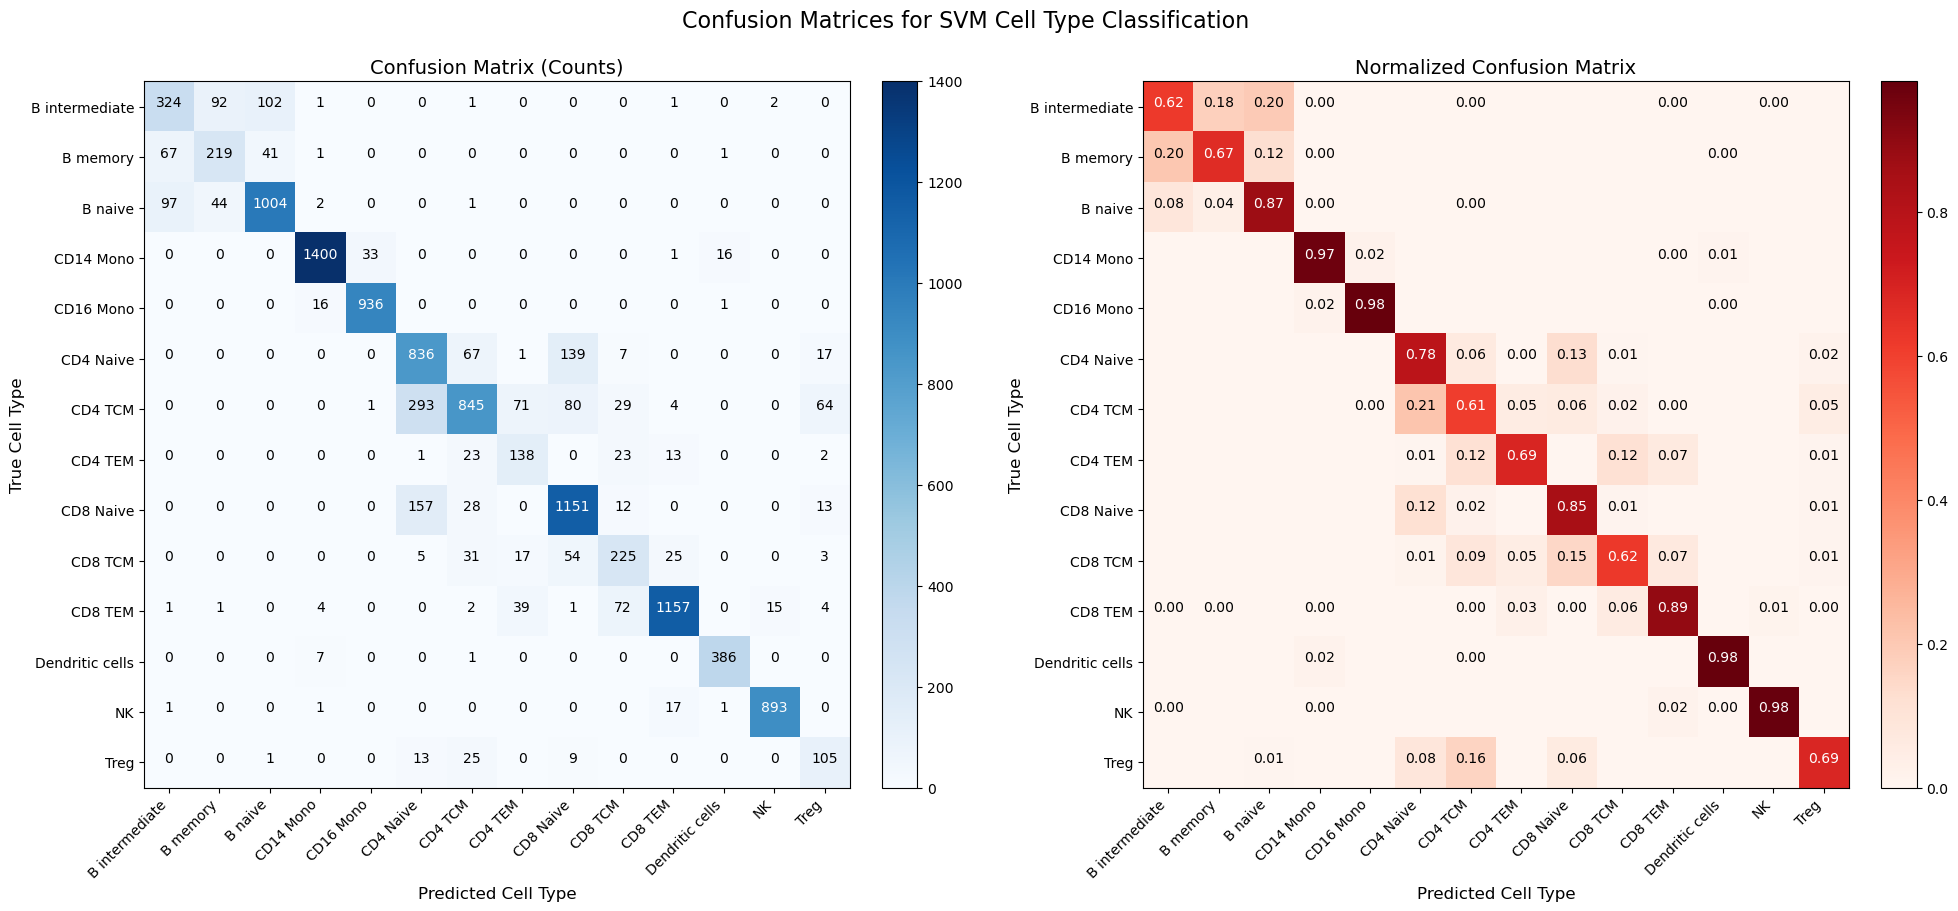

In [9]:
def plot_confusion_matrices(y_val, y_pred, label_encoder):
    """
    Plot both regular and normalized confusion matrices with detailed annotations.
    
    Parameters:
    -----------
    y_val : True validation labels
    y_pred : Predicted labels
    label_encoder : Label encoder used for the dataset
    """
    # Convert to numpy arrays if they aren't already
    y_val_np = cp.asnumpy(y_val) if isinstance(y_val, cp.ndarray) else np.asarray(y_val)
    y_pred_np = cp.asnumpy(y_pred) if isinstance(y_pred, cp.ndarray) else np.asarray(y_pred)
    
    # Get class names from label encoder
    class_names = label_encoder.classes_
    
    # Calculate confusion matrices
    cm = confusion_matrix(y_val_np, y_pred_np)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_norm = np.nan_to_num(cm_norm)  # Replace NaN with 0
    
    # Set up the matplotlib figure for both plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 9))
    fig.suptitle('Confusion Matrices for SVM Cell Type Classification', fontsize=16)
    
    # Regular confusion matrix plot
    im1 = ax1.imshow(cm, interpolation='nearest', cmap='Blues')
    ax1.set_title('Confusion Matrix (Counts)', fontsize=14)
    fig.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
    
    # Normalized confusion matrix plot
    im2 = ax2.imshow(cm_norm, interpolation='nearest', cmap='Reds')
    ax2.set_title('Normalized Confusion Matrix', fontsize=14)
    fig.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
    
    # Common settings for both plots
    for ax in [ax1, ax2]:
        tick_marks = np.arange(len(class_names))
        ax.set_xticks(tick_marks)
        ax.set_yticks(tick_marks)
        ax.set_xticklabels(class_names, rotation=45, ha='right', fontsize=10)
        ax.set_yticklabels(class_names, fontsize=10)
        ax.set_ylabel('True Cell Type', fontsize=12)
        ax.set_xlabel('Predicted Cell Type', fontsize=12)
    
    # Fill in values on the regular confusion matrix
    thresh1 = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax1.text(j, i, format(cm[i, j], 'd'),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh1 else "black")
    
    # Fill in values on the normalized confusion matrix
    thresh2 = 0.5
    for i in range(cm_norm.shape[0]):
        for j in range(cm_norm.shape[1]):
            if not np.isnan(cm_norm[i, j]) and cm_norm[i, j] > 0:
                ax2.text(j, i, format(cm_norm[i, j], '.2f'),
                        horizontalalignment="center",
                        color="white" if cm_norm[i, j] > thresh2 else "black")
    
    plt.tight_layout()
    fig.subplots_adjust(top=0.90)
    
    # Save the plot
    plt.savefig(os.path.join(PLOT_DIR, 'svm_confusion_matrices.png'), dpi=300, bbox_inches='tight')
    plt.show()

# Get predictions if not already available
if 'y_pred' not in metrics_dict:
    X_val_gpu = cp.asarray(X_val) if not isinstance(X_val, cp.ndarray) else X_val
    y_pred_gpu = best_model.predict(X_val_gpu)
    y_pred = cp.asnumpy(y_pred_gpu) if isinstance(y_pred_gpu, cp.ndarray) else y_pred_gpu
else:
    y_pred = metrics_dict['y_pred']

# Plot confusion matrices
plot_confusion_matrices(y_val, y_pred, label_encoder)

#### Plotting ROC and Precision-Recall Curves
This function generates ROC and Precision-Recall curves for each class, allowing for a detailed analysis of the model's performance across different thresholds. It also calculates the AUC for each curve, providing a quantitative measure of the model's discriminative ability.


ROC CURVE ANALYSIS


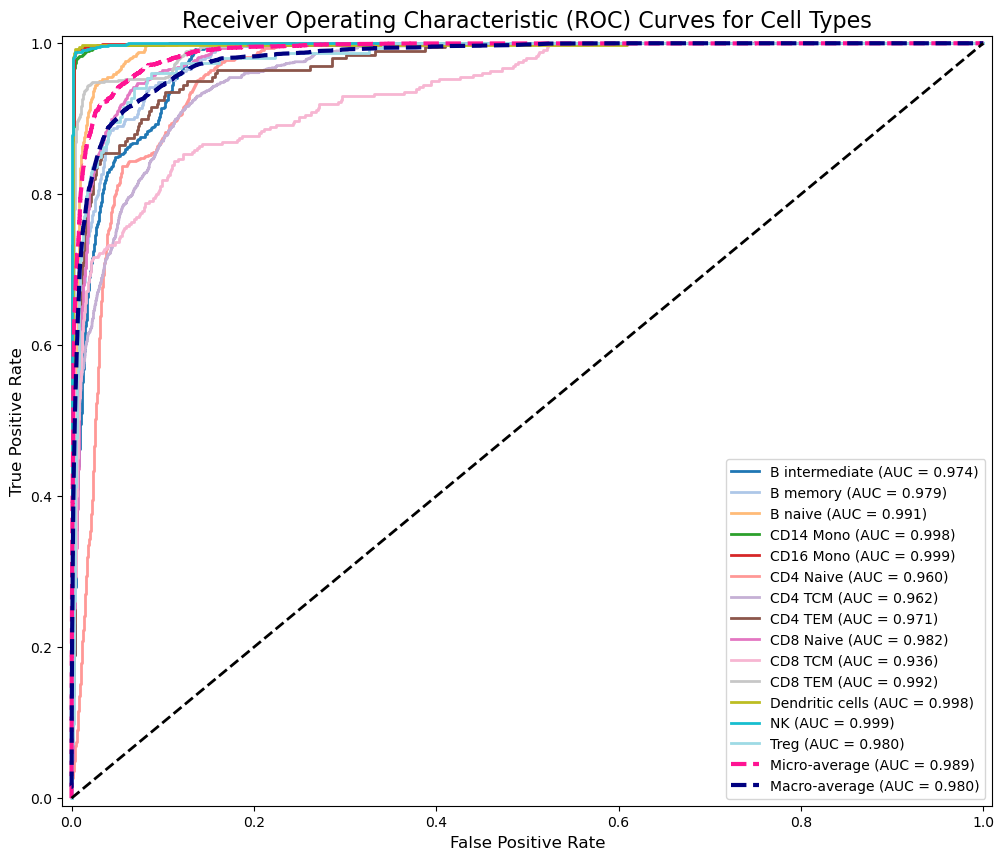


ROC AUC Summary:
Micro-average AUC: 0.9889
Macro-average AUC: 0.9801

Best performing class: NK (AUC: 0.9991)
Worst performing class: CD8 TCM (AUC: 0.9357)

AUC for each cell type (sorted):
Rank  Cell Type            AUC       
----------------------------------------
1     NK                   0.9991
2     CD16 Mono            0.9991
3     CD14 Mono            0.9983
4     Dendritic cells      0.9976
5     CD8 TEM              0.9917
6     B naive              0.9909
7     CD8 Naive            0.9818
8     Treg                 0.9799
9     B memory             0.9793
10    B intermediate       0.9745
11    CD4 TEM              0.9714
12    CD4 TCM              0.9617
13    CD4 Naive            0.9595
14    CD8 TCM              0.9357


In [11]:
def plot_roc_curves(best_model, X_val, y_val, label_encoder, inverse_mapping):
    """
    Generate and plot ROC curves for each class in a one-vs-rest fashion.
    
    Parameters:
    -----------
    best_model : The trained SVM model
    X_val : Validation features
    y_val : Validation labels
    label_encoder : Label encoder used for the dataset
    inverse_mapping : Mapping from integer labels to original labels
    """
    print("\n" + "="*80)
    print("ROC CURVE ANALYSIS")
    print("="*80)
    
    # Convert data as needed
    X_val_gpu = cp.asarray(X_val) if not isinstance(X_val, cp.ndarray) else X_val
    y_val_np = cp.asnumpy(y_val) if isinstance(y_val, cp.ndarray) else np.asarray(y_val)
    
    # Get probabilities
    try:
        y_val_proba = best_model.predict_proba(X_val_gpu)
        if isinstance(y_val_proba, cp.ndarray):
            y_val_proba = cp.asnumpy(y_val_proba)
    except Exception as e:
        print(f"Error getting probabilities: {e}")
        print("ROC curve analysis requires probability estimates.")
        return
    
    # Get unique class values and names
    class_values = np.unique(y_val_np)
    class_names = label_encoder.classes_
    n_classes = len(class_values)
    
    # Create binary labels for each class
    y_binary = label_binarize(y_val_np, classes=class_values)
    
    # Initialize figure
    plt.figure(figsize=(12, 10))
    
    # Colors for ROC curves
    colors = plt.cm.tab20(np.linspace(0, 1, n_classes))
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    # Track classes with highest and lowest AUC
    best_auc = -1
    worst_auc = 2
    best_class = worst_class = 0
    
    # Calculate micro-average ROC curve and ROC area
    y_pred = np.array(y_val_proba)
    
    # For each class
    for i, class_idx in enumerate(class_values):
        # Get original class index
        orig_class_idx = inverse_mapping.get(class_idx, class_idx)
        
        # For binary classification
        if n_classes == 2 and i == 0:
            fpr[i], tpr[i], _ = roc_curve(y_binary, y_pred[:, 1])
        else:
            # For multiclass
            fpr[i], tpr[i], _ = roc_curve(y_binary[:, i], y_pred[:, i])
        
        roc_auc[i] = auc(fpr[i], tpr[i])
        
        # Track best and worst performing classes
        if roc_auc[i] > best_auc:
            best_auc = roc_auc[i]
            best_class = class_idx
        if roc_auc[i] < worst_auc:
            worst_auc = roc_auc[i]
            worst_class = class_idx
        
        # Plot ROC curve for this class
        class_name = class_names[orig_class_idx] if orig_class_idx < len(class_names) else f"Class {class_idx}"
        plt.plot(fpr[i], tpr[i], lw=2, color=colors[i],
                label=f'{class_name} (AUC = {roc_auc[i]:.3f})')
    
    # Calculate and plot micro-average ROC curve and ROC area
    micro_fpr, micro_tpr, _ = roc_curve(y_binary.ravel(), y_pred.ravel())
    micro_auc = auc(micro_fpr, micro_tpr)
    plt.plot(micro_fpr, micro_tpr, lw=3, linestyle='--', color='deeppink',
            label=f'Micro-average (AUC = {micro_auc:.3f})')
    
    # Calculate and plot macro-average ROC curve and ROC area
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    
    mean_tpr /= n_classes
    macro_auc = auc(all_fpr, mean_tpr)
    
    plt.plot(all_fpr, mean_tpr, lw=3, linestyle='--', color='navy',
            label=f'Macro-average (AUC = {macro_auc:.3f})')
    
    # Add random chance line
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    
    # Set up the plot
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('Receiver Operating Characteristic (ROC) Curves for Cell Types', fontsize=16)
    plt.legend(loc="lower right", fontsize=10)
    
    # Save the plot
    plt.savefig(os.path.join(PLOT_DIR, 'svm_roc_curves.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print summary statistics
    print("\nROC AUC Summary:")
    print(f"Micro-average AUC: {micro_auc:.4f}")
    print(f"Macro-average AUC: {macro_auc:.4f}")
    
    # Print best and worst performing classes
    best_orig_idx = inverse_mapping.get(best_class, best_class)
    worst_orig_idx = inverse_mapping.get(worst_class, worst_class)
    
    best_class_name = class_names[best_orig_idx] if best_orig_idx < len(class_names) else f"Class {best_class}"
    worst_class_name = class_names[worst_orig_idx] if worst_orig_idx < len(class_names) else f"Class {worst_class}"
    
    print(f"\nBest performing class: {best_class_name} (AUC: {best_auc:.4f})")
    print(f"Worst performing class: {worst_class_name} (AUC: {worst_auc:.4f})")
    
    # Print AUC for each class in descending order
    print("\nAUC for each cell type (sorted):")
    auc_values = [(i, roc_auc[i]) for i in range(n_classes)]
    auc_values.sort(key=lambda x: x[1], reverse=True)
    
    print(f"{'Rank':<5} {'Cell Type':<20} {'AUC':<10}")
    print("-" * 40)
    for rank, (i, auc_val) in enumerate(auc_values, 1):
        class_idx = class_values[i]
        orig_idx = inverse_mapping.get(class_idx, class_idx)
        class_name = class_names[orig_idx] if orig_idx < len(class_names) else f"Class {class_idx}"
        print(f"{rank:<5} {class_name:<20} {auc_val:.4f}")

# Execute the ROC curve analysis
plot_roc_curves(best_model, X_val, y_val, label_encoder, inverse_mapping)


PRECISION-RECALL CURVE ANALYSIS


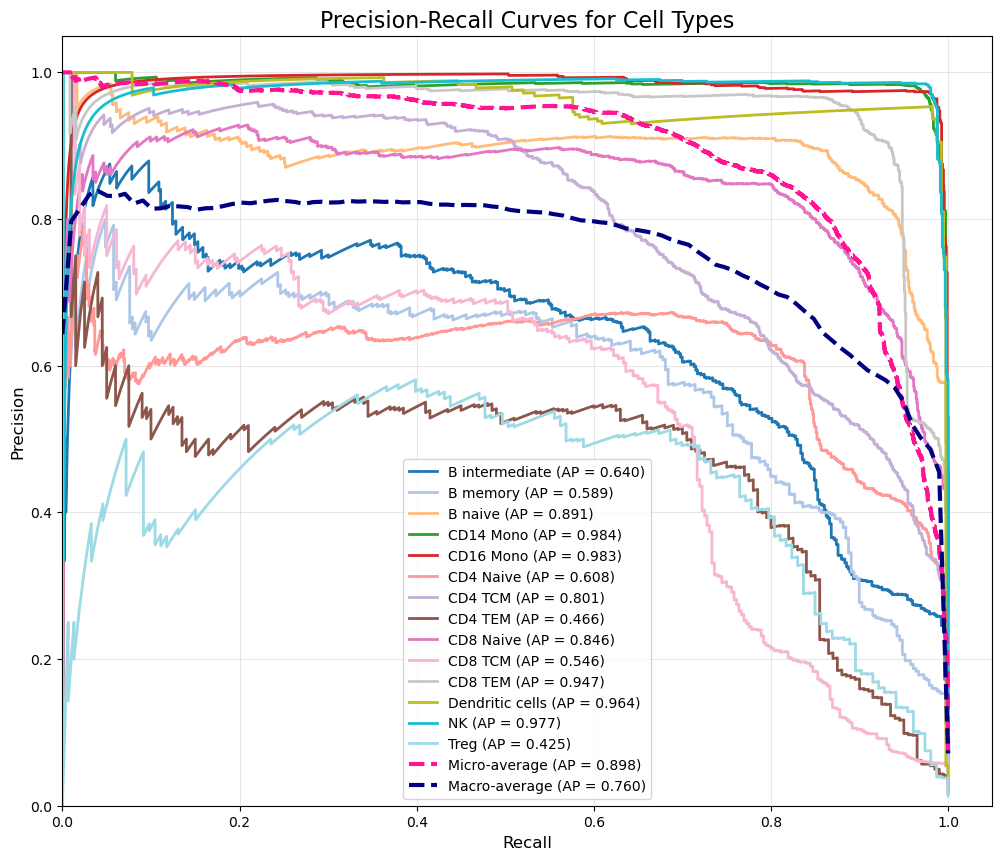


Precision-Recall Summary:
Micro-average AP: 0.8981
Macro-average AP: 0.7597

Best performing class: CD14 Mono (AP: 0.9838)
Worst performing class: Treg (AP: 0.4253)

Average Precision for each cell type (sorted):
Rank  Cell Type            AP        
----------------------------------------
1     CD14 Mono            0.9838
2     CD16 Mono            0.9833
3     NK                   0.9770
4     Dendritic cells      0.9640
5     CD8 TEM              0.9472
6     B naive              0.8911
7     CD8 Naive            0.8465
8     CD4 TCM              0.8007
9     B intermediate       0.6401
10    CD4 Naive            0.6084
11    B memory             0.5890
12    CD8 TCM              0.5456
13    CD4 TEM              0.4663
14    Treg                 0.4253


In [12]:
def plot_precision_recall_curves(best_model, X_val, y_val, label_encoder, inverse_mapping):
    """
    Generate and plot precision-recall curves for each class.
    
    Parameters:
    -----------
    best_model : The trained SVM model
    X_val : Validation features
    y_val : Validation labels
    label_encoder : Label encoder used for the dataset
    inverse_mapping : Mapping from integer labels to original labels
    """
    print("\n" + "="*80)
    print("PRECISION-RECALL CURVE ANALYSIS")
    print("="*80)
    
    # Convert data as needed
    X_val_gpu = cp.asarray(X_val) if not isinstance(X_val, cp.ndarray) else X_val
    y_val_np = cp.asnumpy(y_val) if isinstance(y_val, cp.ndarray) else np.asarray(y_val)
    
    # Get probabilities
    try:
        y_val_proba = best_model.predict_proba(X_val_gpu)
        if isinstance(y_val_proba, cp.ndarray):
            y_val_proba = cp.asnumpy(y_val_proba)
    except Exception as e:
        print(f"Error getting probabilities: {e}")
        print("Precision-Recall curve analysis requires probability estimates.")
        return
    
    # Get unique class values and names
    class_values = np.unique(y_val_np)
    class_names = label_encoder.classes_
    n_classes = len(class_values)
    
    # Create binary labels for each class
    y_binary = label_binarize(y_val_np, classes=class_values)
    
    # Initialize figure
    plt.figure(figsize=(12, 10))
    
    # Colors for PR curves
    colors = plt.cm.tab20(np.linspace(0, 1, n_classes))
    
    # Compute precision-recall curve and average precision for each class
    precision = dict()
    recall = dict()
    avg_precision = dict()
    
    # Track classes with highest and lowest AP
    best_ap = -1
    worst_ap = 2
    best_class = worst_class = 0
    
    # For each class
    for i, class_idx in enumerate(class_values):
        # Get original class index
        orig_class_idx = inverse_mapping.get(class_idx, class_idx)
        
        # For binary classification
        if n_classes == 2 and i == 0:
            precision[i], recall[i], _ = precision_recall_curve(y_binary, y_val_proba[:, 1])
            avg_precision[i] = auc(recall[i], precision[i])
        else:
            # For multiclass
            precision[i], recall[i], _ = precision_recall_curve(y_binary[:, i], y_val_proba[:, i])
            avg_precision[i] = auc(recall[i], precision[i])
        
        # Track best and worst performing classes
        if avg_precision[i] > best_ap:
            best_ap = avg_precision[i]
            best_class = class_idx
        if avg_precision[i] < worst_ap:
            worst_ap = avg_precision[i]
            worst_class = class_idx
        
        # Plot precision-recall curve for this class
        class_name = class_names[orig_class_idx] if orig_class_idx < len(class_names) else f"Class {class_idx}"
        plt.plot(recall[i], precision[i], lw=2, color=colors[i],
                label=f'{class_name} (AP = {avg_precision[i]:.3f})')
    
    # Calculate and plot micro-average precision-recall curve
    y_micro = y_binary.ravel()
    y_proba_micro = y_val_proba.reshape(-1)
    micro_precision, micro_recall, _ = precision_recall_curve(y_micro, y_proba_micro)
    micro_ap = auc(micro_recall, micro_precision)
    plt.plot(micro_recall, micro_precision, lw=3, linestyle='--', color='deeppink',
            label=f'Micro-average (AP = {micro_ap:.3f})')
    
    # Calculate macro-average precision-recall curve
    # Interpolate PR curves at a common set of recall values
    all_recall = np.linspace(0, 1, 100)
    mean_precision = np.zeros_like(all_recall)
    
    for i in range(n_classes):
        # Interpolate PR curve for this class
        mean_precision += np.interp(all_recall, recall[i][::-1], precision[i][::-1])
    
    # Average over all classes
    mean_precision /= n_classes
    macro_ap = auc(all_recall, mean_precision)
    
    plt.plot(all_recall, mean_precision, lw=3, linestyle='--', color='navy',
            label=f'Macro-average (AP = {macro_ap:.3f})')
    
    # Set up the plot
    plt.xlim([0.0, 1.05])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.title('Precision-Recall Curves for Cell Types', fontsize=16)
    plt.legend(loc="best", fontsize=10)
    plt.grid(alpha=0.3)
    
    # Save the plot
    plt.savefig(os.path.join(PLOT_DIR, 'svm_precision_recall_curves.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print summary statistics
    print("\nPrecision-Recall Summary:")
    print(f"Micro-average AP: {micro_ap:.4f}")
    print(f"Macro-average AP: {macro_ap:.4f}")
    
    # Print best and worst performing classes
    best_orig_idx = inverse_mapping.get(best_class, best_class)
    worst_orig_idx = inverse_mapping.get(worst_class, worst_class)
    
    best_class_name = class_names[best_orig_idx] if best_orig_idx < len(class_names) else f"Class {best_class}"
    worst_class_name = class_names[worst_orig_idx] if worst_orig_idx < len(class_names) else f"Class {worst_class}"
    
    print(f"\nBest performing class: {best_class_name} (AP: {best_ap:.4f})")
    print(f"Worst performing class: {worst_class_name} (AP: {worst_ap:.4f})")
    
    # Print AP for each class in descending order
    print("\nAverage Precision for each cell type (sorted):")
    ap_values = [(i, avg_precision[i]) for i in range(n_classes)]
    ap_values.sort(key=lambda x: x[1], reverse=True)
    
    print(f"{'Rank':<5} {'Cell Type':<20} {'AP':<10}")
    print("-" * 40)
    for rank, (i, ap_val) in enumerate(ap_values, 1):
        class_idx = class_values[i]
        orig_idx = inverse_mapping.get(class_idx, class_idx)
        class_name = class_names[orig_idx] if orig_idx < len(class_names) else f"Class {class_idx}"
        print(f"{rank:<5} {class_name:<20} {ap_val:.4f}")

# Execute the precision-recall curve analysis
plot_precision_recall_curves(best_model, X_val, y_val, label_encoder, inverse_mapping)

#### Analyzing and plotting confidence distributions
This function analyzes the distribution of prediction confidence scores for each class. It provides insights into the model's certainty in its predictions and helps identify classes where the model is less confident, which may indicate areas for improvement.


PREDICTION CONFIDENCE ANALYSIS

Overall Confidence Statistics:
Mean confidence: 0.7858
Median confidence: 0.8099
Min confidence: 0.3539
Max confidence: 0.9819
Standard deviation: 0.1438

Confidence for Correct Predictions:
Mean: 0.8124
Median: 0.8220
Min: 0.3745
Max: 0.9819

Confidence for Incorrect Predictions:
Mean: 0.6523
Median: 0.6386
Min: 0.3539
Max: 0.9656

Confidence by Cell Type:
Cell Type            Mean Conf    Median Conf  Min Conf     Max Conf     Count   
--------------------------------------------------------------------------------
B intermediate       0.6739       0.7027       0.4043       0.8798       523     
B memory             0.6523       0.6501       0.4454       0.9612       329     
B naive              0.7915       0.8216       0.3984       0.9569       1148    
CD14 Mono            0.9467       0.9592       0.5779       0.9819       1450    
CD16 Mono            0.9419       0.9452       0.5952       0.9656       953     
CD4 Naive            0.5936       

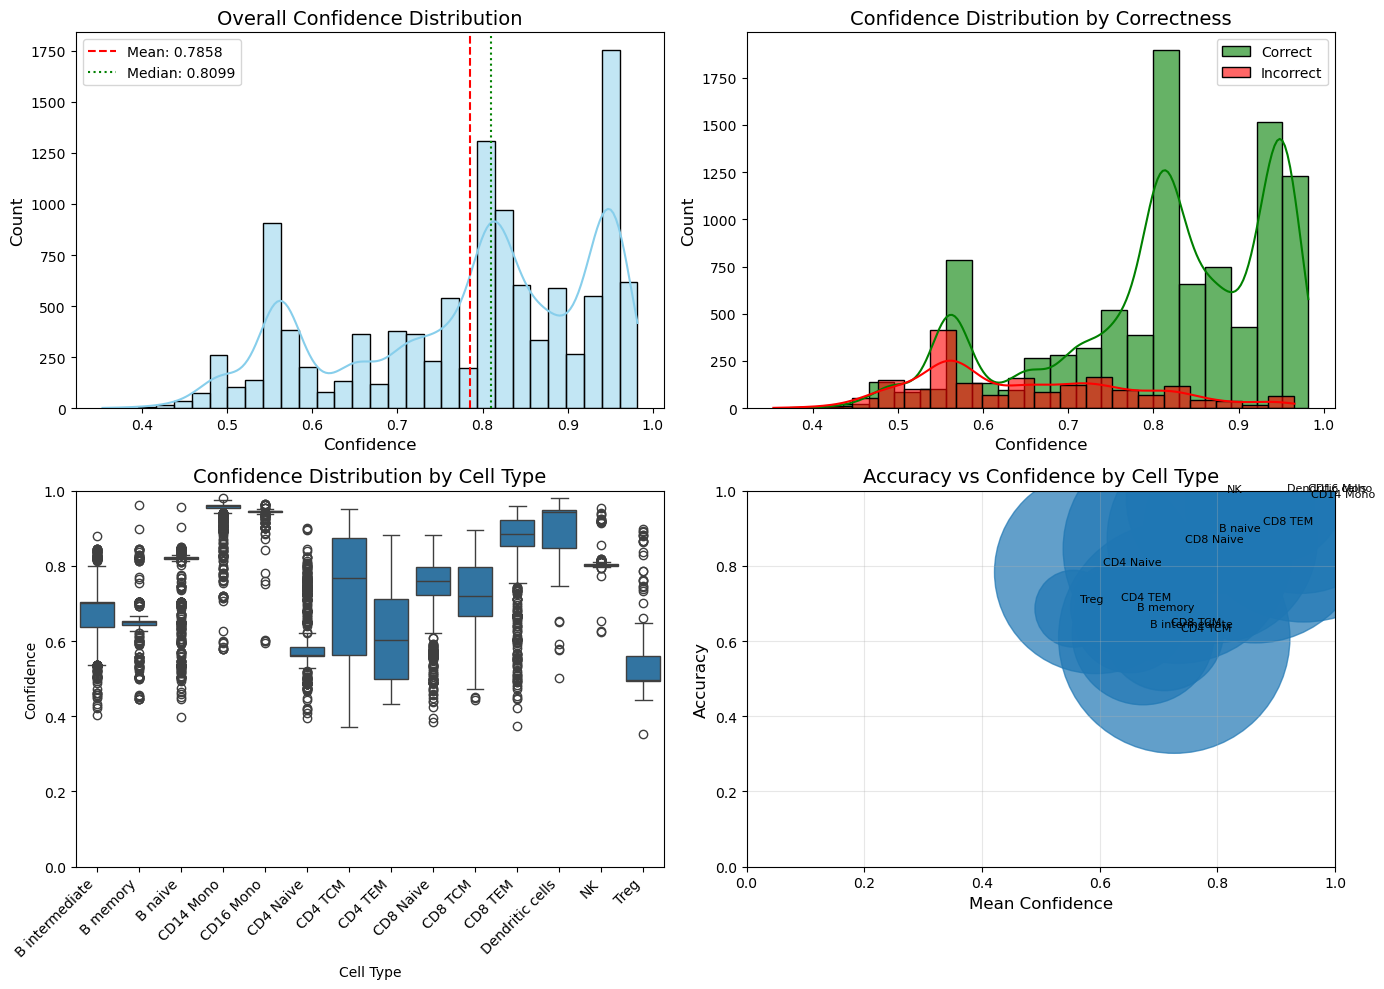

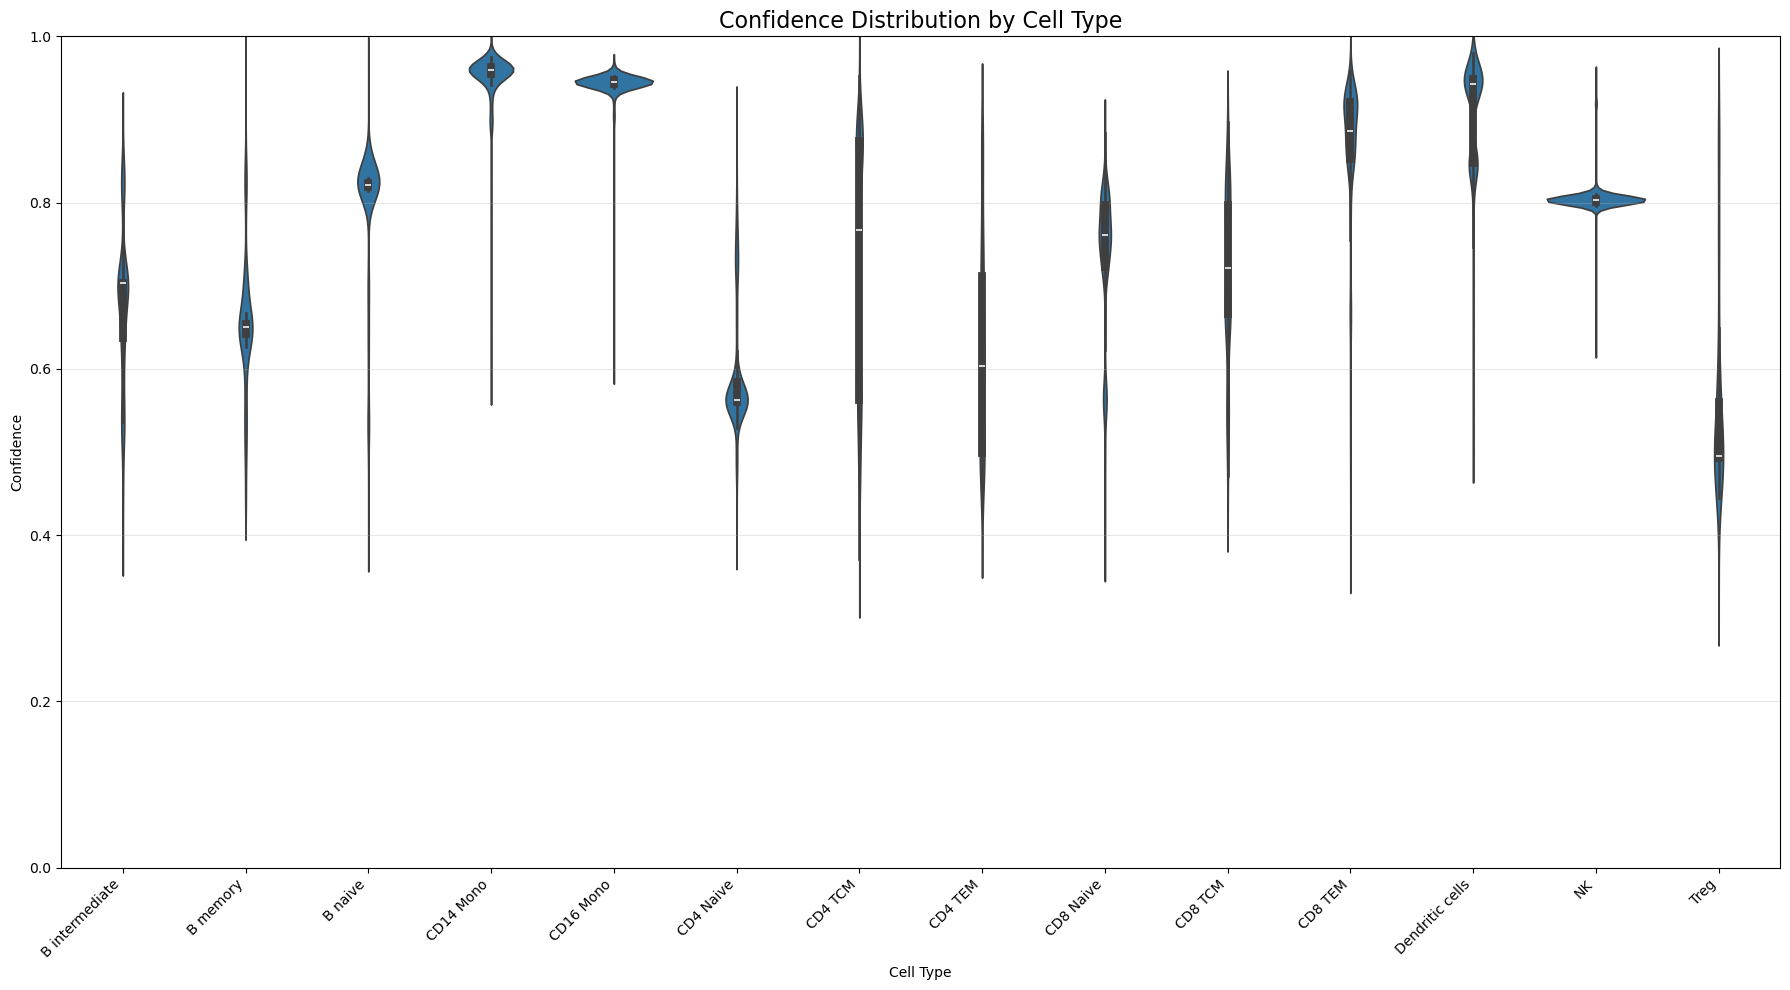

In [14]:
def analyze_confidence_distribution(best_model, X_val, y_val, label_encoder, inverse_mapping):
    """
    Analyze the confidence distribution of predictions across different cell types.
    
    Parameters:
    -----------
    best_model : The trained SVM model
    X_val : Validation features
    y_val : Validation labels
    label_encoder : Label encoder used for the dataset
    inverse_mapping : Mapping from integer labels to original labels
    """
    print("\n" + "="*80)
    print("PREDICTION CONFIDENCE ANALYSIS")
    print("="*80)
    
    # Convert data to GPU if needed
    X_val_gpu = cp.asarray(X_val) if not isinstance(X_val, cp.ndarray) else X_val
    y_val_np = cp.asnumpy(y_val) if isinstance(y_val, cp.ndarray) else np.asarray(y_val)
    
    # Get predictions and probabilities
    try:
        y_val_pred_gpu = best_model.predict(X_val_gpu)
        y_val_pred = cp.asnumpy(y_val_pred_gpu) if isinstance(y_val_pred_gpu, cp.ndarray) else y_val_pred_gpu
        
        y_val_proba = best_model.predict_proba(X_val_gpu)
        if isinstance(y_val_proba, cp.ndarray):
            y_val_proba = cp.asnumpy(y_val_proba)
        
        # Extract max probability (confidence) for each prediction
        confidences = np.max(y_val_proba, axis=1)
        
        # Calculate overall statistics
        mean_confidence = np.mean(confidences)
        median_confidence = np.median(confidences)
        min_confidence = np.min(confidences)
        max_confidence = np.max(confidences)
        std_confidence = np.std(confidences)
        
        print("\nOverall Confidence Statistics:")
        print(f"Mean confidence: {mean_confidence:.4f}")
        print(f"Median confidence: {median_confidence:.4f}")
        print(f"Min confidence: {min_confidence:.4f}")
        print(f"Max confidence: {max_confidence:.4f}")
        print(f"Standard deviation: {std_confidence:.4f}")
        
        # Get statistics for correct vs incorrect predictions
        correct_mask = (y_val_pred == y_val_np)
        correct_conf = confidences[correct_mask]
        incorrect_conf = confidences[~correct_mask]
        
        if len(correct_conf) > 0:
            print("\nConfidence for Correct Predictions:")
            print(f"Mean: {np.mean(correct_conf):.4f}")
            print(f"Median: {np.median(correct_conf):.4f}")
            print(f"Min: {np.min(correct_conf):.4f}")
            print(f"Max: {np.max(correct_conf):.4f}")
        
        if len(incorrect_conf) > 0:
            print("\nConfidence for Incorrect Predictions:")
            print(f"Mean: {np.mean(incorrect_conf):.4f}")
            print(f"Median: {np.median(incorrect_conf):.4f}")
            print(f"Min: {np.min(incorrect_conf):.4f}")
            print(f"Max: {np.max(incorrect_conf):.4f}")
        
        # Get confidence by class
        class_values = np.unique(y_val_np)
        class_names = label_encoder.classes_
        
        print("\nConfidence by Cell Type:")
        print(f"{'Cell Type':<20} {'Mean Conf':<12} {'Median Conf':<12} {'Min Conf':<12} {'Max Conf':<12} {'Count':<8}")
        print("-" * 80)
        
        class_conf_data = []
        
        for class_idx in class_values:
            # Get original class index
            orig_class_idx = inverse_mapping.get(class_idx, class_idx)
            
            # Get class name
            class_name = class_names[orig_class_idx] if orig_class_idx < len(class_names) else f"Class {class_idx}"
            
            # Get data for this class
            class_mask = (y_val_np == class_idx)
            class_conf = confidences[class_mask]
            
            if len(class_conf) > 0:
                class_mean = np.mean(class_conf)
                class_median = np.median(class_conf)
                class_min = np.min(class_conf)
                class_max = np.max(class_conf)
                
                print(f"{class_name:<20} {class_mean:<12.4f} {class_median:<12.4f} {class_min:<12.4f} {class_max:<12.4f} {len(class_conf):<8}")
                
                # Store data for plotting
                class_conf_data.append({
                    'class_name': class_name,
                    'confidences': class_conf,
                    'mean': class_mean,
                    'correct': correct_mask[class_mask],
                    'count': len(class_conf)
                })
        
        # Visualize confidence distributions
        plt.figure(figsize=(14, 10))
        
        # Plot 1: Overall confidence distribution
        plt.subplot(2, 2, 1)
        sns.histplot(confidences, bins=30, kde=True, color='skyblue')
        plt.axvline(mean_confidence, color='red', linestyle='--', label=f'Mean: {mean_confidence:.4f}')
        plt.axvline(median_confidence, color='green', linestyle=':', label=f'Median: {median_confidence:.4f}')
        plt.title('Overall Confidence Distribution', fontsize=14)
        plt.xlabel('Confidence', fontsize=12)
        plt.ylabel('Count', fontsize=12)
        plt.legend()
        
        # Plot 2: Confidence for correct vs incorrect predictions
        plt.subplot(2, 2, 2)
        if len(correct_conf) > 0:
            sns.histplot(correct_conf, bins=20, kde=True, color='green', alpha=0.6, label='Correct')
        if len(incorrect_conf) > 0:
            sns.histplot(incorrect_conf, bins=20, kde=True, color='red', alpha=0.6, label='Incorrect')
        plt.title('Confidence Distribution by Correctness', fontsize=14)
        plt.xlabel('Confidence', fontsize=12)
        plt.ylabel('Count', fontsize=12)
        plt.legend()
        
        # Plot 3: Box plot of confidence by class
        plt.subplot(2, 2, 3)
        class_names = [data['class_name'] for data in class_conf_data]
        class_confidences = [data['confidences'] for data in class_conf_data]
        
        boxplot_data = pd.DataFrame({
            'Cell Type': np.concatenate([[class_name] * len(conf) for class_name, conf in zip(class_names, class_confidences)]),
            'Confidence': np.concatenate(class_confidences)
        })
        
        sns.boxplot(x='Cell Type', y='Confidence', data=boxplot_data)
        plt.title('Confidence Distribution by Cell Type', fontsize=14)
        plt.xticks(rotation=45, ha='right')
        plt.ylim(0, 1)
        
        # Plot 4: Mean confidence vs class accuracy
        plt.subplot(2, 2, 4)
        
        class_accuracy = []
        for data in class_conf_data:
            if len(data['correct']) > 0:
                acc = np.mean(data['correct'])
            else:
                acc = 0
            class_accuracy.append(acc)
        
        class_mean_conf = [data['mean'] for data in class_conf_data]
        class_counts = [data['count'] for data in class_conf_data]
        
        plt.scatter(class_mean_conf, class_accuracy, s=[c * 20 for c in class_counts], alpha=0.7)
        
        # Add text labels for each point
        for i, (x, y, label, count) in enumerate(zip(class_mean_conf, class_accuracy, class_names, class_counts)):
            plt.annotate(label, (x, y), fontsize=8, 
                        xytext=(5, 5), textcoords='offset points')
            
        plt.xlabel('Mean Confidence', fontsize=12)
        plt.ylabel('Accuracy', fontsize=12)
        plt.title('Accuracy vs Confidence by Cell Type', fontsize=14)
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.grid(alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(os.path.join(PLOT_DIR, 'svm_confidence_analysis.png'), dpi=300, bbox_inches='tight')
        plt.show()
        
        # Create violin plot of confidence distributions by cell type
        plt.figure(figsize=(18, 10))
        sns.violinplot(x='Cell Type', y='Confidence', data=boxplot_data, inner='box')
        plt.title('Confidence Distribution by Cell Type', fontsize=16)
        plt.xticks(rotation=45, ha='right')
        plt.ylim(0, 1)
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.savefig(os.path.join(PLOT_DIR, 'svm_confidence_violinplot.png'), dpi=300, bbox_inches='tight')
        plt.show()
        
    except Exception as e:
        print(f"Error analyzing confidence distributions: {e}")
        print("This analysis requires a model with predict_proba capability.")

# Run the confidence distribution analysis
analyze_confidence_distribution(best_model, X_val, y_val, label_encoder, inverse_mapping)

#### Visualizing UMAP to analyze misclassifications
This function visualizes the UMAP projection of the data, colored by true labels and predicted labels. It provides a visual representation of the model's performance, highlighting areas of misclassification and clustering patterns in the data.


UMAP VISUALIZATION & MISCLASSIFICATION ANALYSIS

Fitting UMAP projection...


/home/aaryeshad/mambaforge/envs/gpu_ml_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/aaryeshad/mambaforge/envs/gpu_ml_env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


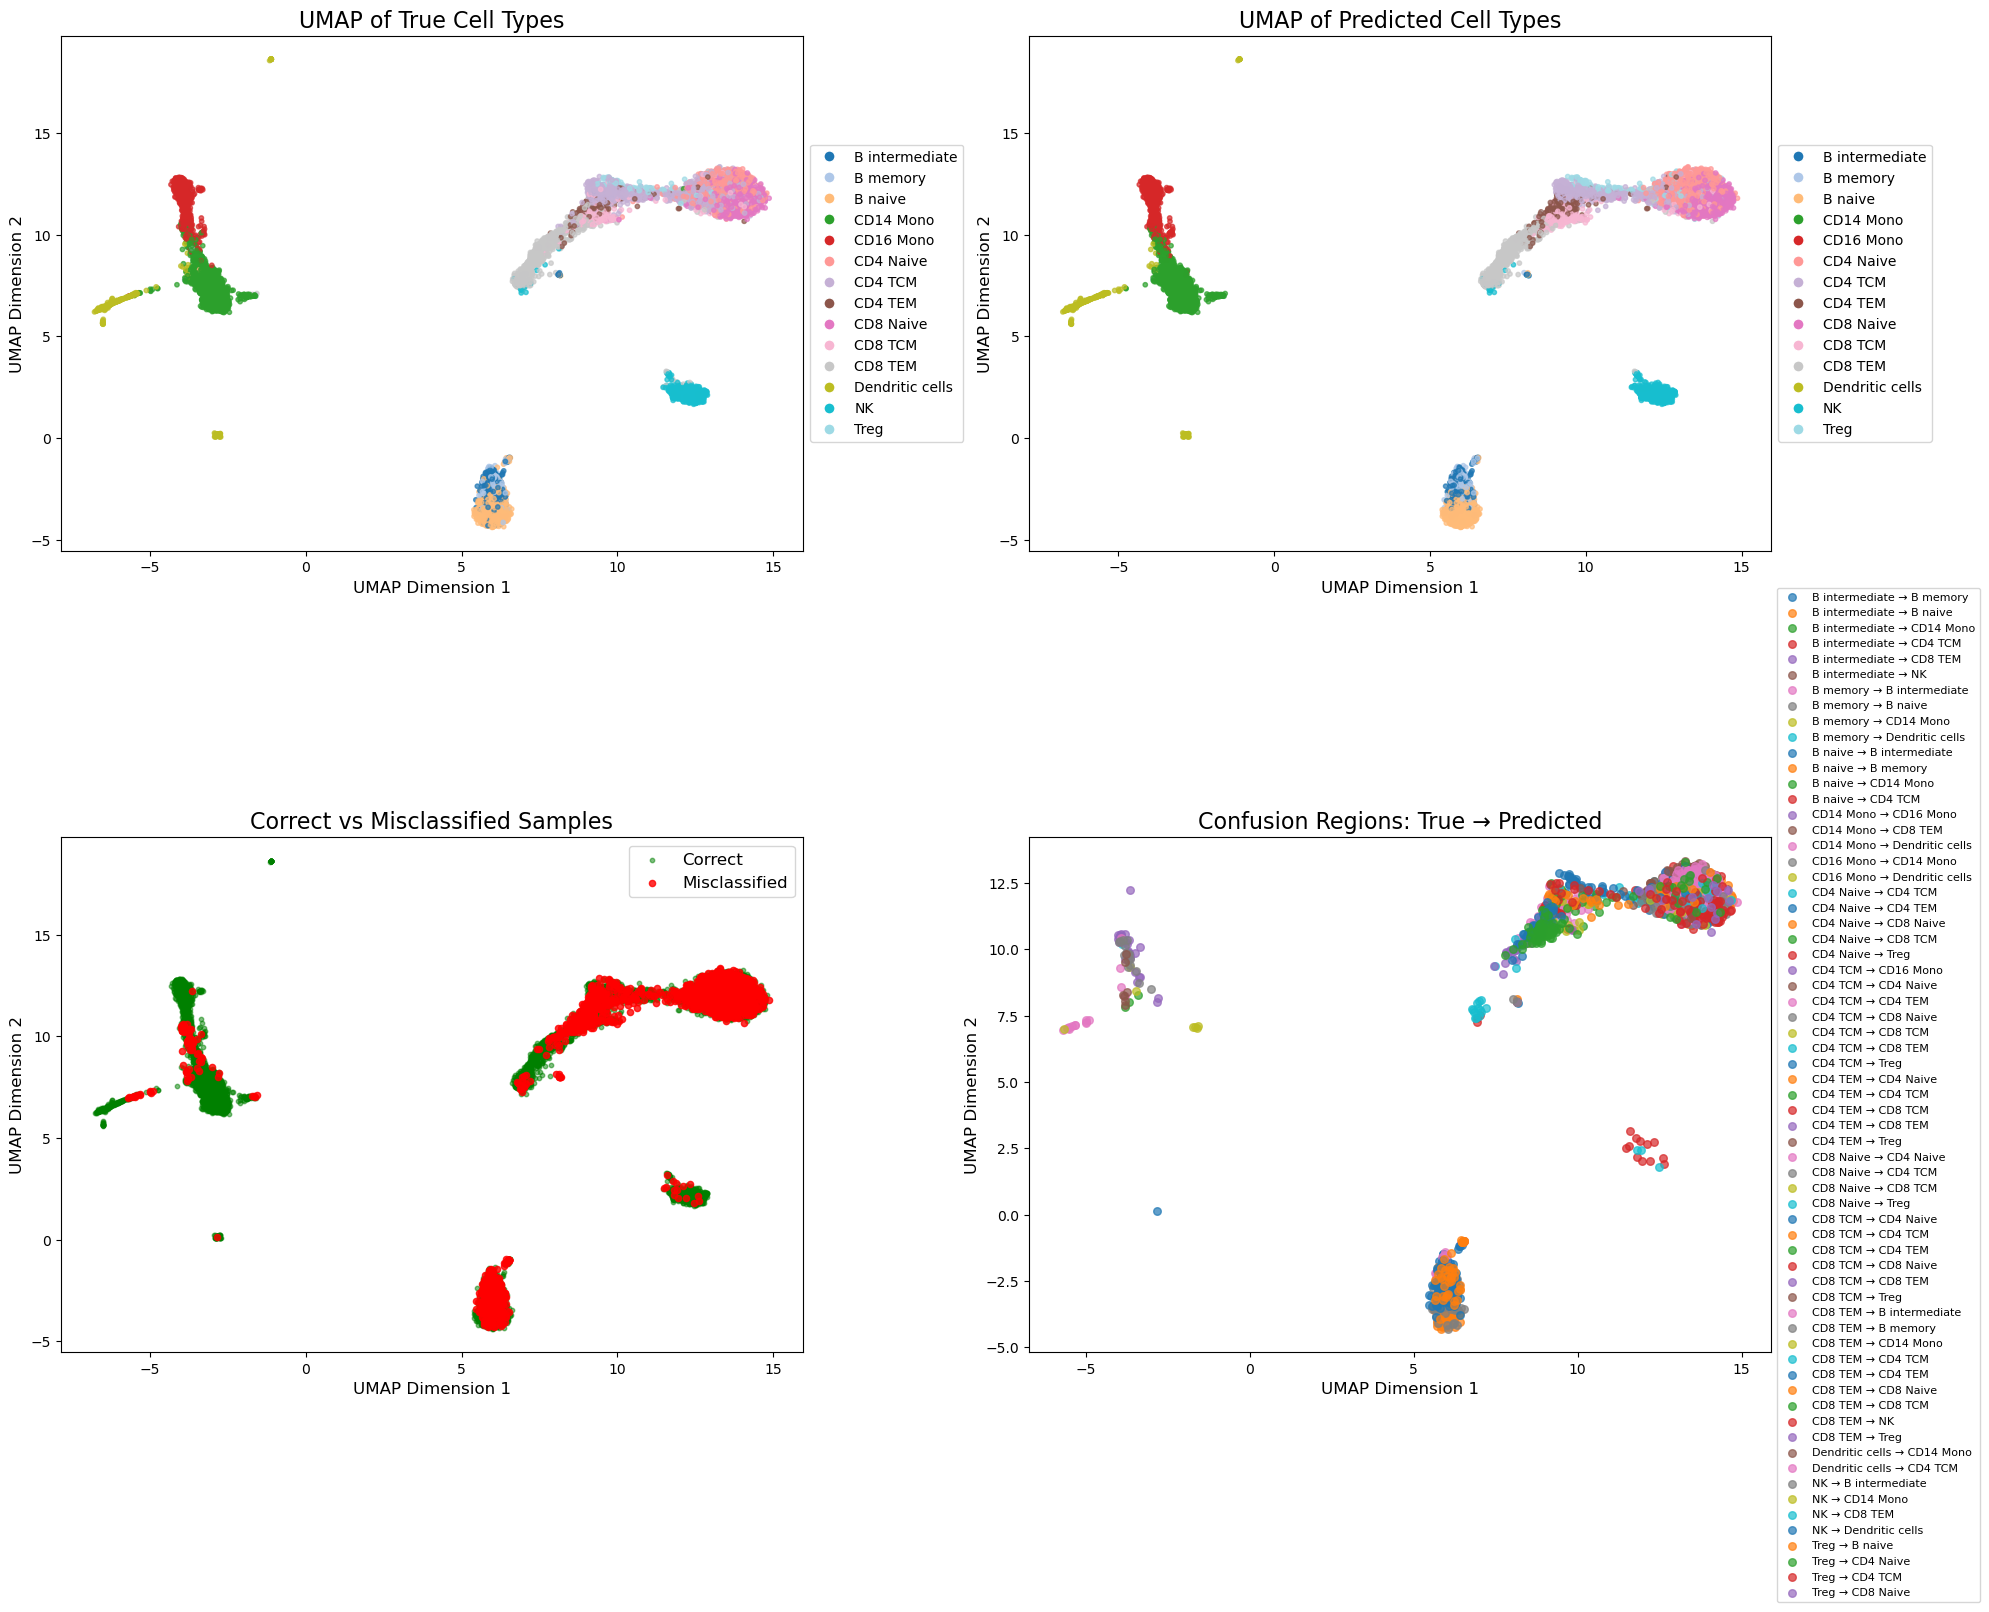


Top Misclassification Patterns:
True Cell Type       Predicted As         Count      % of True Class     
----------------------------------------------------------------------
CD4 TCM              CD4 Naive            293           21.12%
CD8 Naive            CD4 Naive            157           11.54%
CD4 Naive            CD8 Naive            139           13.03%
B intermediate       B naive              102           19.50%
B naive              B intermediate       97             8.45%
B intermediate       B memory             92            17.59%
CD4 TCM              CD8 Naive            80             5.77%
CD8 TEM              CD8 TCM              72             5.56%
CD4 TCM              CD4 TEM              71             5.12%
B memory             B intermediate       67            20.36%
CD4 Naive            CD4 TCM              67             6.28%
CD4 TCM              Treg                 64             4.61%
CD8 TCM              CD8 Naive            54            15.00%
B n

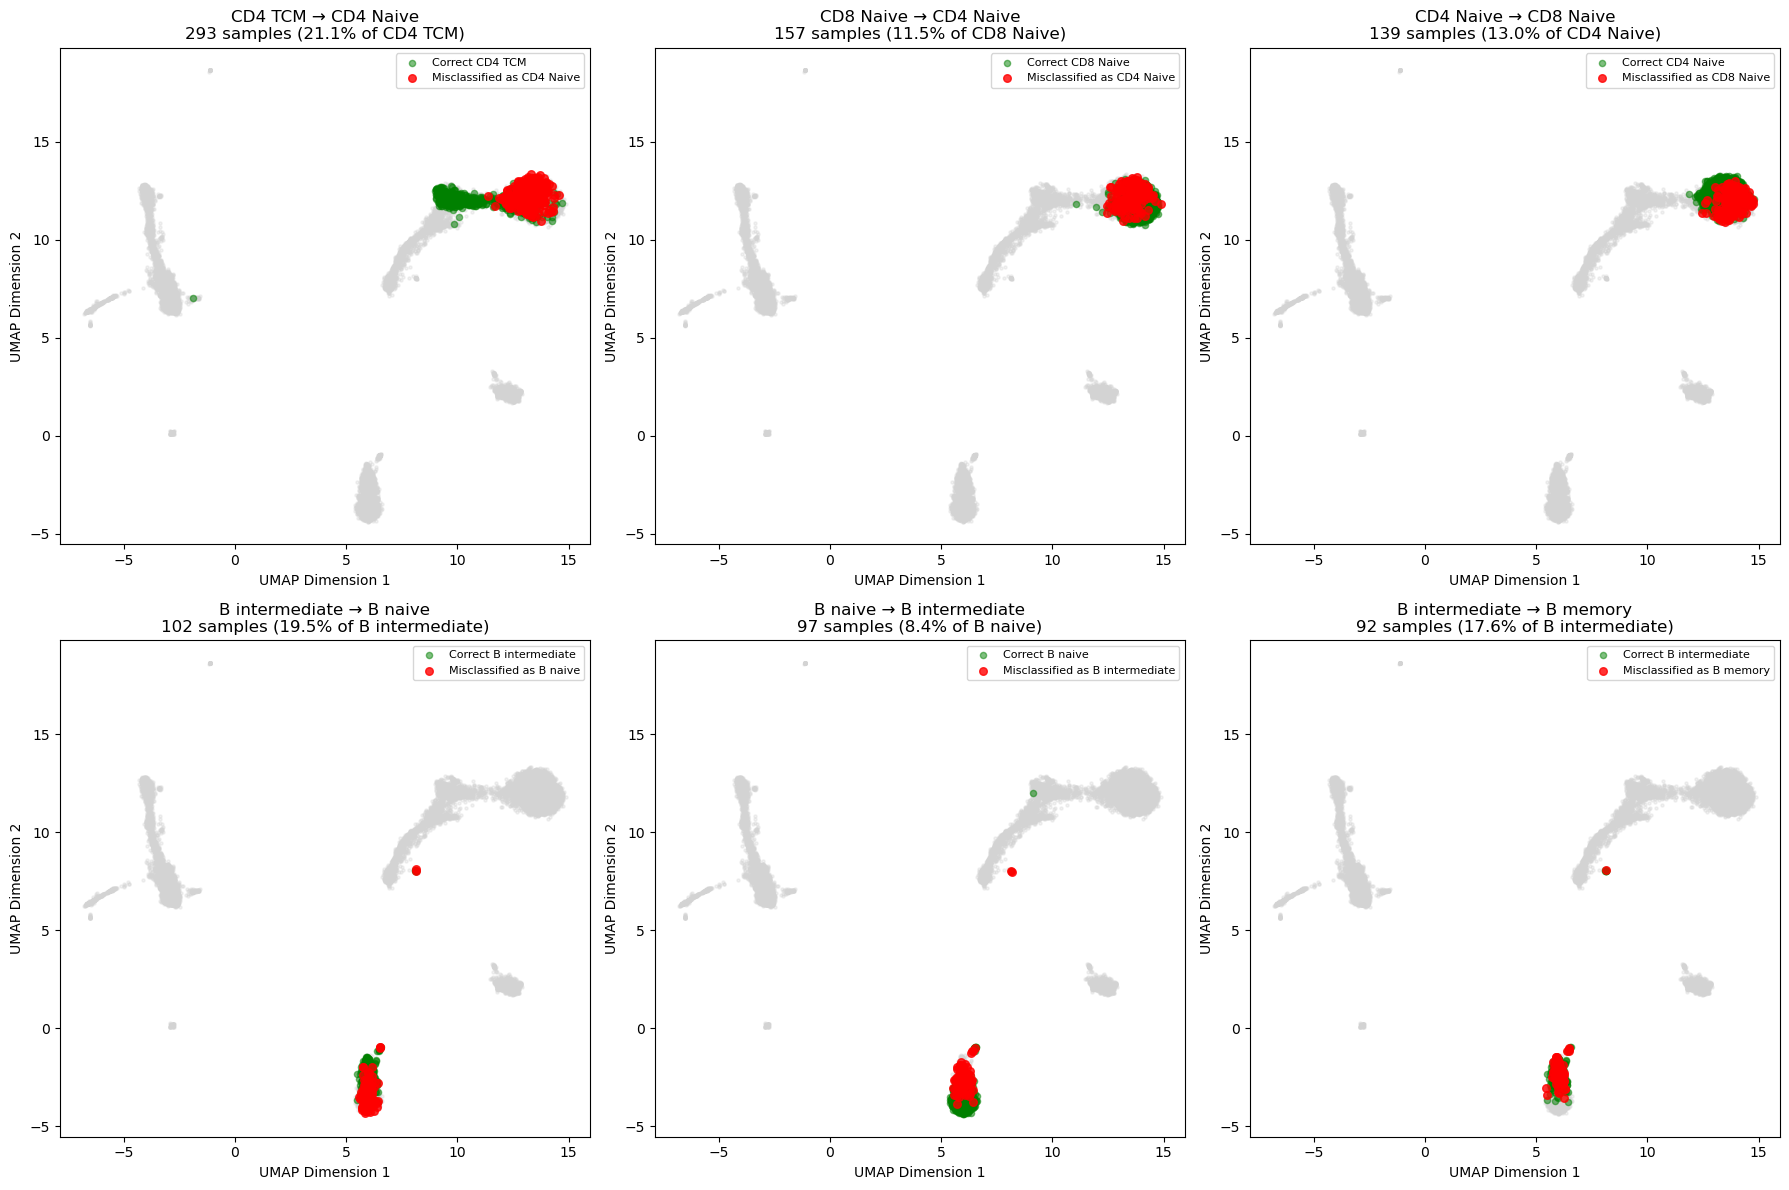

In [15]:
def visualize_with_umap(X_val, y_val, y_pred, label_encoder, inverse_mapping):
    """
    Create UMAP visualizations to analyze model performance and misclassifications.
    
    Parameters:
    -----------
    X_val : Validation features
    y_val : True validation labels
    y_pred : Predicted labels
    label_encoder : Label encoder used for the dataset
    inverse_mapping : Mapping from integer labels to original labels
    """
    print("\n" + "="*80)
    print("UMAP VISUALIZATION & MISCLASSIFICATION ANALYSIS")
    print("="*80)
    
    # Convert data to numpy arrays if needed
    X_val_np = cp.asnumpy(X_val) if isinstance(X_val, cp.ndarray) else np.asarray(X_val)
    y_val_np = cp.asnumpy(y_val) if isinstance(y_val, cp.ndarray) else np.asarray(y_val)
    y_pred_np = cp.asnumpy(y_pred) if isinstance(y_pred, cp.ndarray) else np.asarray(y_pred)
    
    print("\nFitting UMAP projection...")
    # Create a UMAP projection
    reducer = umap.UMAP(
        n_neighbors=15,
        min_dist=0.1,
        n_components=2,
        metric='euclidean',
        random_state=RAND_SEED
    )
    
    # Fit and transform the data
    umap_embedding = reducer.fit_transform(X_val_np)
    
    # Calculate misclassification information
    misclassified = (y_val_np != y_pred_np)
    correct = ~misclassified
    
    # Get class names
    class_names = label_encoder.classes_
    
    # Create a figure with multiple subplots
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    
    # Plot 1: True cell types
    ax = axes[0, 0]
    scatter = ax.scatter(umap_embedding[:, 0], umap_embedding[:, 1], 
                        c=y_val_np, cmap='tab20', s=10, alpha=0.7)
    
    # Create a custom legend
    unique_classes = np.unique(y_val_np)
    legend_elements = []
    for cls in unique_classes:
        orig_cls = inverse_mapping.get(cls, cls)
        if orig_cls < len(class_names):
            class_name = class_names[orig_cls]
        else:
            class_name = f"Class {cls}"
        color = scatter.cmap(scatter.norm(cls))
        legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', 
                                        markerfacecolor=color, markersize=8, label=class_name))
    
    # Place legend outside the plot
    ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
    ax.set_title('UMAP of True Cell Types', fontsize=16)
    ax.set_xlabel('UMAP Dimension 1', fontsize=12)
    ax.set_ylabel('UMAP Dimension 2', fontsize=12)
    
    # Plot 2: Predicted cell types
    ax = axes[0, 1]
    scatter = ax.scatter(umap_embedding[:, 0], umap_embedding[:, 1], 
                        c=y_pred_np, cmap='tab20', s=10, alpha=0.7)
    
    # Create a custom legend
    unique_pred_classes = np.unique(y_pred_np)
    legend_elements = []
    for cls in unique_pred_classes:
        orig_cls = inverse_mapping.get(cls, cls)
        if orig_cls < len(class_names):
            class_name = class_names[orig_cls]
        else:
            class_name = f"Class {cls}"
        color = scatter.cmap(scatter.norm(cls))
        legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', 
                                        markerfacecolor=color, markersize=8, label=class_name))
    
    # Place legend outside the plot
    ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
    ax.set_title('UMAP of Predicted Cell Types', fontsize=16)
    ax.set_xlabel('UMAP Dimension 1', fontsize=12)
    ax.set_ylabel('UMAP Dimension 2', fontsize=12)
    
    # Plot 3: Correct and misclassified samples
    ax = axes[1, 0]
    ax.scatter(umap_embedding[correct, 0], umap_embedding[correct, 1], 
            c='green', label='Correct', s=10, alpha=0.5)
    ax.scatter(umap_embedding[misclassified, 0], umap_embedding[misclassified, 1], 
            c='red', label='Misclassified', s=20, alpha=0.8)
    ax.legend(fontsize=12)
    ax.set_title('Correct vs Misclassified Samples', fontsize=16)
    ax.set_xlabel('UMAP Dimension 1', fontsize=12)
    ax.set_ylabel('UMAP Dimension 2', fontsize=12)
    
    # Plot 4: Confusion regions (highlight the misclassified points with their true and predicted labels)
    ax = axes[1, 1]
    
    # Plot only misclassified points
    if np.any(misclassified):
        # Create a scatter plot with a systematic color scheme
        for true_cls in unique_classes:
            for pred_cls in unique_pred_classes:
                if true_cls != pred_cls:  # Only for misclassifications
                    # Find points with this true class and predicted class combination
                    mask = (y_val_np == true_cls) & (y_pred_np == pred_cls)
                    if np.any(mask):
                        # Get class names
                        true_name = class_names[inverse_mapping.get(true_cls, true_cls)] if inverse_mapping.get(true_cls, true_cls) < len(class_names) else f"Class {true_cls}"
                        pred_name = class_names[inverse_mapping.get(pred_cls, pred_cls)] if inverse_mapping.get(pred_cls, pred_cls) < len(class_names) else f"Class {pred_cls}"
                        
                        # Plot with different shapes and colors
                        ax.scatter(umap_embedding[mask, 0], umap_embedding[mask, 1], 
                                s=30, alpha=0.7, label=f"{true_name} → {pred_name}")
        
        # Customize legend with smaller font
        ax.legend(fontsize=8, loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
    else:
        ax.text(0.5, 0.5, "No misclassifications!", 
            horizontalalignment='center', fontsize=16)
    
    ax.set_title('Confusion Regions: True → Predicted', fontsize=16)
    ax.set_xlabel('UMAP Dimension 1', fontsize=12)
    ax.set_ylabel('UMAP Dimension 2', fontsize=12)
    
    # Adjust layout and save
    plt.tight_layout()
    plt.savefig(os.path.join(PLOT_DIR, 'svm_umap_visualization.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    # Create a focused visualization of misclassification patterns
    if np.any(misclassified):
        # Get most common misclassifications
        print("\nTop Misclassification Patterns:")
        confusion_patterns = {}
        for true_cls in unique_classes:
            for pred_cls in unique_pred_classes:
                if true_cls != pred_cls:
                    mask = (y_val_np == true_cls) & (y_pred_np == pred_cls)
                    count = np.sum(mask)
                    if count > 0:
                        true_name = class_names[inverse_mapping.get(true_cls, true_cls)] if inverse_mapping.get(true_cls, true_cls) < len(class_names) else f"Class {true_cls}"
                        pred_name = class_names[inverse_mapping.get(pred_cls, pred_cls)] if inverse_mapping.get(pred_cls, pred_cls) < len(class_names) else f"Class {pred_cls}"
                        confusion_patterns[(true_name, pred_name)] = (count, mask)
        
        # Sort by count and display
        sorted_patterns = sorted(confusion_patterns.items(), key=lambda x: x[1][0], reverse=True)
        
        print(f"{'True Cell Type':<20} {'Predicted As':<20} {'Count':<10} {'% of True Class':<20}")
        print("-" * 70)
        
        for (true_name, pred_name), (count, mask) in sorted_patterns[:15]:  # Show top 15
            # Calculate what percentage of the true class this represents
            true_cls_count = np.sum(y_val_np == np.unique(y_val_np)[list(class_names).index(true_name) if true_name in class_names else -1])
            percentage = count / true_cls_count * 100 if true_cls_count > 0 else 0
            print(f"{true_name:<20} {pred_name:<20} {count:<10} {percentage:>8.2f}%")
        
        # Visualize top 6 confusion patterns
        if len(sorted_patterns) > 0:
            n_patterns = min(6, len(sorted_patterns))
            
            fig, axes = plt.subplots(2, 3, figsize=(18, 12))
            axes = axes.flatten()
            
            for i, ((true_name, pred_name), (count, mask)) in enumerate(sorted_patterns[:n_patterns]):
                ax = axes[i]
                
                # Plot all points as background in light gray
                ax.scatter(umap_embedding[:, 0], umap_embedding[:, 1], 
                        c='lightgray', s=5, alpha=0.3)
                
                # Plot points of the true class that were correctly classified
                true_cls = np.unique(y_val_np)[list(class_names).index(true_name) if true_name in class_names else -1]
                correct_mask = (y_val_np == true_cls) & (y_pred_np == true_cls)
                ax.scatter(umap_embedding[correct_mask, 0], umap_embedding[correct_mask, 1], 
                        c='green', s=20, alpha=0.5, label=f'Correct {true_name}')
                
                # Plot the misclassified points of this pattern
                ax.scatter(umap_embedding[mask, 0], umap_embedding[mask, 1], 
                        c='red', s=30, alpha=0.8, label=f'Misclassified as {pred_name}')
                
                # Add percentage information
                true_cls_count = np.sum(y_val_np == true_cls)
                percentage = count / true_cls_count * 100 if true_cls_count > 0 else 0
                
                ax.set_title(f'{true_name} → {pred_name}\n{count} samples ({percentage:.1f}% of {true_name})', fontsize=12)
                ax.legend(fontsize=8)
                ax.set_xlabel('UMAP Dimension 1', fontsize=10)
                ax.set_ylabel('UMAP Dimension 2', fontsize=10)
            
            # If we have fewer than 6 patterns, remove empty subplots
            for i in range(n_patterns, 6):
                fig.delaxes(axes[i])
            
            plt.tight_layout()
            plt.savefig(os.path.join(PLOT_DIR, 'svm_confusion_patterns.png'), dpi=300, bbox_inches='tight')
            plt.show()
            
    else:
        print("\nNo misclassifications to analyze!")

# Get predictions if not already available
if 'y_pred' not in metrics_dict:
    X_val_gpu = cp.asarray(X_val) if not isinstance(X_val, cp.ndarray) else X_val
    y_pred_gpu = best_model.predict(X_val_gpu)
    y_pred = cp.asnumpy(y_pred_gpu) if isinstance(y_pred_gpu, cp.ndarray) else y_pred_gpu
else:
    y_pred = metrics_dict['y_pred']

# Run UMAP visualization
visualize_with_umap(X_val, y_val, y_pred, label_encoder, inverse_mapping)

#### Visualization of performance metrics
This function generates a series of plots to visualize the model's performance metrics, including accuracy, precision, recall, and F1 score. It provides a comprehensive overview of the model's performance across different classes and helps identify areas for improvement.


PERFORMANCE METRICS VISUALIZATION


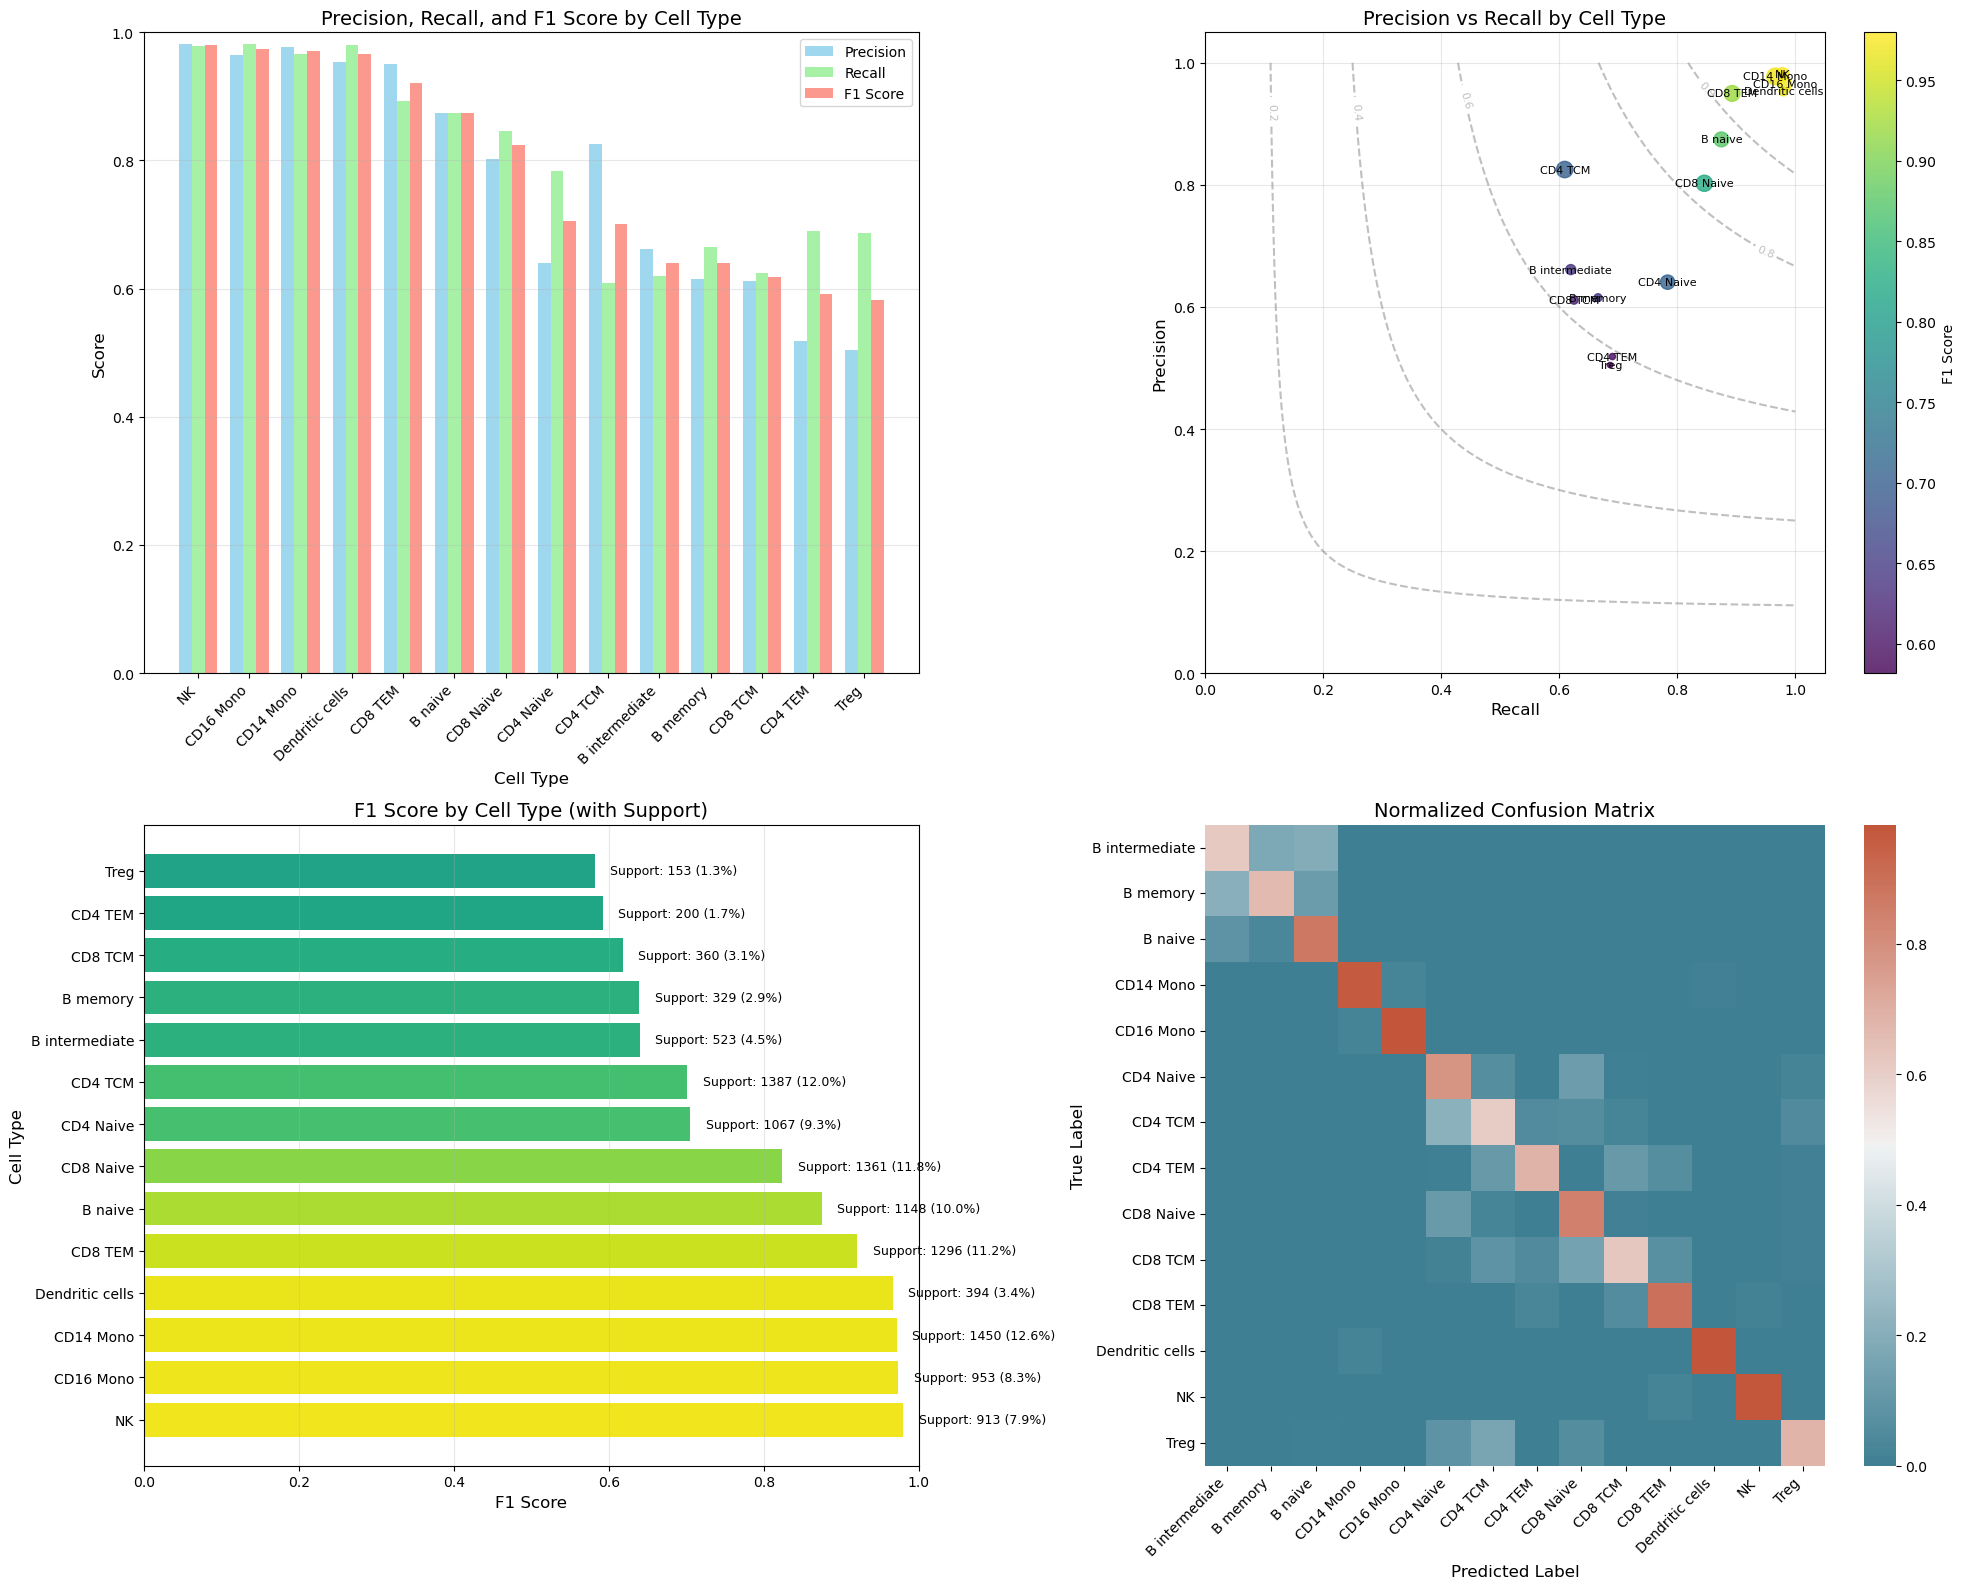


Performance Metrics Summary:
          Class Precision Recall F1 Score  Support Support %
             NK    0.9813 0.9781   0.9797      913     7.92%
      CD16 Mono    0.9649 0.9822   0.9735      953     8.26%
      CD14 Mono    0.9777 0.9655   0.9715     1450    12.57%
Dendritic cells    0.9531 0.9797   0.9662      394     3.42%
        CD8 TEM    0.9499 0.8927   0.9204     1296    11.24%
        B naive    0.8746 0.8746   0.8746     1148     9.95%
      CD8 Naive    0.8026 0.8457   0.8236     1361    11.80%
      CD4 Naive    0.6406 0.7835   0.7049     1067     9.25%
        CD4 TCM    0.8252 0.6092   0.7010     1387    12.03%
 B intermediate    0.6612 0.6195   0.6397      523     4.53%
       B memory    0.6152 0.6657   0.6394      329     2.85%
        CD8 TCM    0.6114 0.6250   0.6181      360     3.12%
        CD4 TEM    0.5188 0.6900   0.5923      200     1.73%
           Treg    0.5048 0.6863   0.5817      153     1.33%
        OVERALL    0.7772 0.7998   0.7848    11534   10

In [16]:
def visualize_performance_metrics(y_val, y_pred, label_encoder, inverse_mapping):
    """
    Create detailed visualizations of model performance metrics.
    
    Parameters:
    -----------
    y_val : True validation labels
    y_pred : Predicted labels
    label_encoder : Label encoder used for the dataset
    inverse_mapping : Mapping from integer labels to original labels
    """
    print("\n" + "="*80)
    print("PERFORMANCE METRICS VISUALIZATION")
    print("="*80)
    
    # Convert data to numpy arrays if needed
    y_val_np = cp.asnumpy(y_val) if isinstance(y_val, cp.ndarray) else np.asarray(y_val)
    y_pred_np = cp.asnumpy(y_pred) if isinstance(y_pred, cp.ndarray) else np.asarray(y_pred)
    
    # Get class names
    class_names = label_encoder.classes_
    
    # Calculate per-class metrics
    precision = precision_score(y_val_np, y_pred_np, average=None, zero_division=0)
    recall = recall_score(y_val_np, y_pred_np, average=None, zero_division=0)
    f1 = f1_score(y_val_np, y_pred_np, average=None, zero_division=0)
    
    # Create a comprehensive metrics plot
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    
    # Get metrics data in a dataframe for easier plotting
    metrics_data = []
    
    for i, class_name in enumerate(class_names):
        # Find the corresponding index in the metrics arrays
        orig_idx = i
        for mapped_idx, orig_i in inverse_mapping.items():
            if orig_i == i:
                orig_idx = mapped_idx
                break
        
        # Count samples for this class
        class_count = np.sum(y_val_np == orig_idx)
        
        # Get metrics (if index is valid)
        if orig_idx < len(precision):
            class_precision = precision[orig_idx]
            class_recall = recall[orig_idx]
            class_f1 = f1[orig_idx]
        else:
            class_precision = class_recall = class_f1 = 0
        
        # Store data
        metrics_data.append({
            'Class': class_name,
            'Precision': class_precision,
            'Recall': class_recall,
            'F1 Score': class_f1,
            'Support': class_count
        })
    
    # Convert to DataFrame
    metrics_df = pd.DataFrame(metrics_data)
    
    # Sort by F1 score for better visualization
    metrics_df = metrics_df.sort_values('F1 Score', ascending=False)
    
    # Plot 1: Bar chart of precision, recall, and F1 score by class
    ax = axes[0, 0]
    
    # Create a grouped bar chart
    bar_width = 0.25
    index = np.arange(len(metrics_df))
    
    ax.bar(index - bar_width, metrics_df['Precision'], bar_width, 
           label='Precision', color='skyblue', alpha=0.8)
    ax.bar(index, metrics_df['Recall'], bar_width, 
           label='Recall', color='lightgreen', alpha=0.8)
    ax.bar(index + bar_width, metrics_df['F1 Score'], bar_width, 
           label='F1 Score', color='salmon', alpha=0.8)
    
    # Customize the plot
    ax.set_xlabel('Cell Type', fontsize=12)
    ax.set_ylabel('Score', fontsize=12)
    ax.set_title('Precision, Recall, and F1 Score by Cell Type', fontsize=14)
    ax.set_xticks(index)
    ax.set_xticklabels(metrics_df['Class'], rotation=45, ha='right')
    ax.legend()
    ax.set_ylim(0, 1)
    ax.grid(axis='y', alpha=0.3)
    
    # Plot 2: Scatter plot of precision vs recall, with F1 contours
    ax = axes[0, 1]
    
    # Create a scatter plot of precision vs recall
    scatter = ax.scatter(metrics_df['Recall'], metrics_df['Precision'], 
                        s=metrics_df['Support']/10, c=metrics_df['F1 Score'], 
                        cmap='viridis', alpha=0.8)
    
    # Add contour lines for F1 score
    x = np.linspace(0.01, 1, 100)
    y = np.linspace(0.01, 1, 100)
    X, Y = np.meshgrid(x, y)
    Z = 2 * X * Y / (X + Y)  # F1 score formula
    
    contour = ax.contour(X, Y, Z, levels=[0.2, 0.4, 0.6, 0.8, 0.9], 
                        colors='gray', alpha=0.5, linestyles='--')
    ax.clabel(contour, inline=True, fontsize=8)
    
    # Add class labels to the scatter points
    for i, row in metrics_df.iterrows():
        ax.annotate(row['Class'], (row['Recall'], row['Precision']), 
                   fontsize=8, ha='center', va='center')
    
    # Add a color bar for F1 score
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('F1 Score', fontsize=10)
    
    # Customize the plot
    ax.set_xlabel('Recall', fontsize=12)
    ax.set_ylabel('Precision', fontsize=12)
    ax.set_title('Precision vs Recall by Cell Type', fontsize=14)
    ax.set_xlim(0, 1.05)
    ax.set_ylim(0, 1.05)
    ax.grid(alpha=0.3)
    
    # Plot 3: Horizontal bar chart of F1 scores with support information
    ax = axes[1, 0]
    
    # Create a horizontal bar chart
    bars = ax.barh(metrics_df['Class'], metrics_df['F1 Score'], 
                  color=plt.cm.viridis(metrics_df['F1 Score']))
    
    # Add support information
    for i, (f1, support) in enumerate(zip(metrics_df['F1 Score'], metrics_df['Support'])):
        ax.text(max(f1 + 0.02, 0.1), i, f"Support: {support} ({support/sum(metrics_df['Support'])*100:.1f}%)", 
               va='center', fontsize=9)
    
    # Customize the plot
    ax.set_xlabel('F1 Score', fontsize=12)
    ax.set_ylabel('Cell Type', fontsize=12)
    ax.set_title('F1 Score by Cell Type (with Support)', fontsize=14)
    ax.set_xlim(0, 1)
    ax.grid(axis='x', alpha=0.3)
    
    # Plot 4: Confusion matrix heatmap (normalized)
    ax = axes[1, 1]
    
    # Calculate the confusion matrix
    cm = confusion_matrix(y_val_np, y_pred_np)
    
    # Normalize by true class
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_norm = np.nan_to_num(cm_norm)  # Replace NaN with 0
    
    # Create a custom colormap for better visibility
    cmap = sns.diverging_palette(220, 20, as_cmap=True)
    
    # Plot the heatmap
    sns.heatmap(cm_norm, annot=False, fmt='.2f', cmap=cmap, 
               xticklabels=class_names, yticklabels=class_names, ax=ax)
    
    # Customize the plot
    ax.set_xlabel('Predicted Label', fontsize=12)
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_title('Normalized Confusion Matrix', fontsize=14)
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    plt.setp(ax.get_yticklabels(), rotation=0)
    
    # Adjust layout and save
    plt.tight_layout()
    plt.savefig(os.path.join(PLOT_DIR, 'svm_performance_metrics.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    # Create a summary table of metrics
    print("\nPerformance Metrics Summary:")
    metrics_df['Support %'] = metrics_df['Support'] / metrics_df['Support'].sum() * 100
    summary_df = metrics_df[['Class', 'Precision', 'Recall', 'F1 Score', 'Support', 'Support %']]
    
    # Add overall metrics as the last row
    overall_metrics = {
        'Class': 'OVERALL',
        'Precision': precision_score(y_val_np, y_pred_np, average='macro', zero_division=0),
        'Recall': recall_score(y_val_np, y_pred_np, average='macro', zero_division=0),
        'F1 Score': f1_score(y_val_np, y_pred_np, average='macro', zero_division=0),
        'Support': sum(metrics_df['Support']),
        'Support %': 100.0
    }
    summary_df = pd.concat([summary_df, pd.DataFrame([overall_metrics])], ignore_index=True)
    
    # Format and display
    summary_df['Precision'] = summary_df['Precision'].map('{:.4f}'.format)
    summary_df['Recall'] = summary_df['Recall'].map('{:.4f}'.format)
    summary_df['F1 Score'] = summary_df['F1 Score'].map('{:.4f}'.format)
    summary_df['Support %'] = summary_df['Support %'].map('{:.2f}%'.format)
    
    print(summary_df.to_string(index=False))
    
    # Save the metrics to a CSV file
    summary_df.to_csv(os.path.join(RESULTS_DIR, 'svm_performance_metrics.csv'), index=False)
    print(f"\nMetrics saved to {os.path.join(RESULTS_DIR, 'svm_performance_metrics.csv')}")

# Run performance metrics visualization
visualize_performance_metrics(y_val, y_pred, label_encoder, inverse_mapping)

#### Compute and Plot feature importance (Top 30 genes)
This function computes and plots the feature importance scores for the top 30 genes based on their contribution to the model's predictions. It provides insights into the most influential genes for each class and helps identify potential biomarkers for cell type classification.


FEATURE IMPORTANCE ANALYSIS
Non-linear kernel detected, computing permutation importance...
This may take some time...
Error computing permutation importance: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.
Using support vector analysis as an alternative approach...
Error using support vector analysis: Support vectors or dual coefficients are None
Falling back to a feature scaling-based approach...
Used feature variance as a proxy for importance - this is a rough approximation

Top 20 Most Important Genes:
        Gene  Importance
0        LYZ    0.025293
1    HLA-DRA    0.024637
2     S100A9    0.023989
3       CD74    0.021830
4       GNLY    0.020971
5       NKG7    0.018776
6       CTSS    0.017878
7     S100A8    0.017724
8     S100A4    0.016985
9       CST3    0.016710
10      CCL5    0.016660
11      IL32    0.015640
12    TYROBP    0.015182
13      AIF1    0.014969
14     NEAT1    0.014893
15       LTB    0.014519
16  HLA

/tmp/ipykernel_27156/1633312049.py:131: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Gene', data=top_features, palette='viridis')


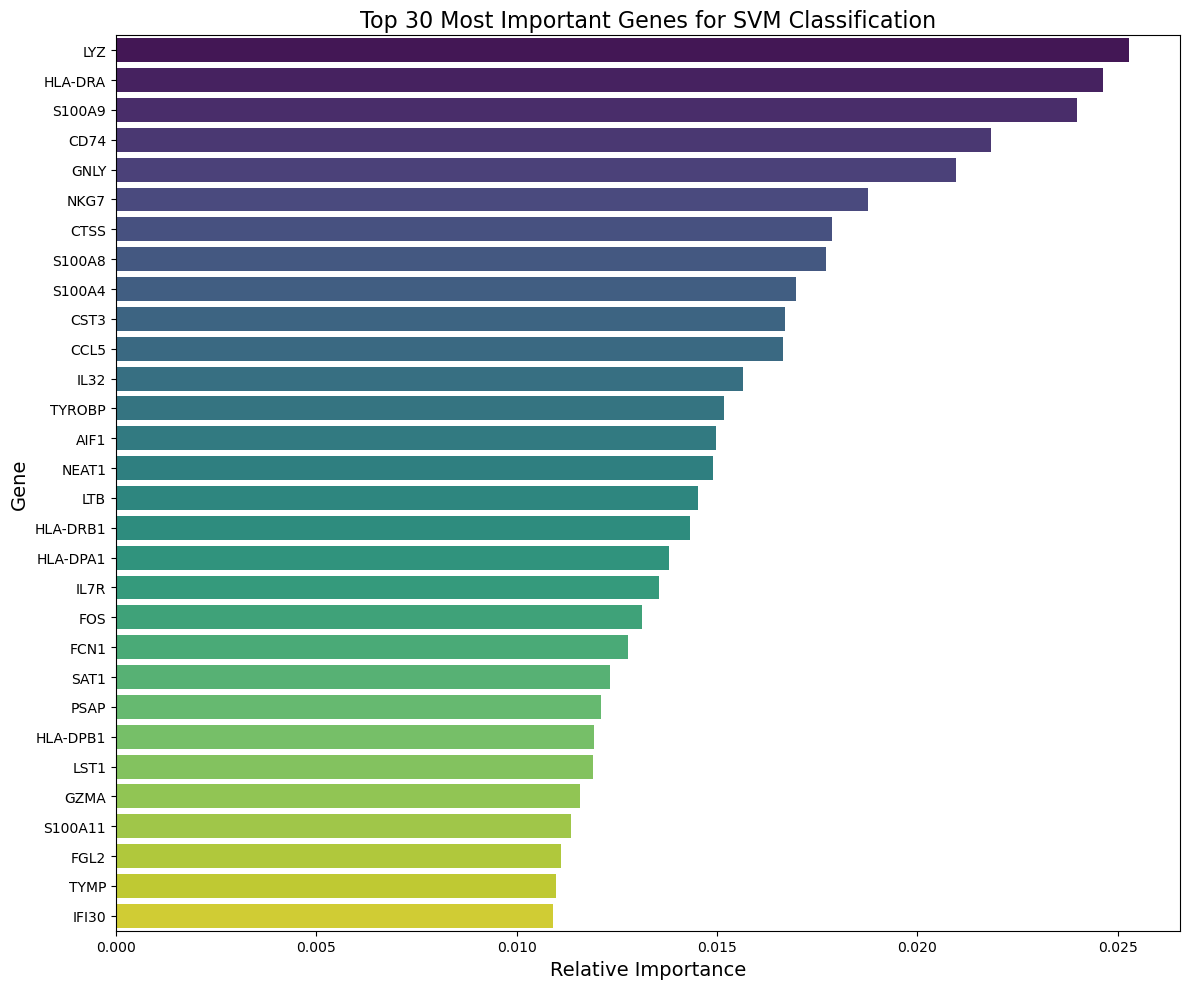


Full feature importance saved to /mnt/f/cwd_ml/cs7641/Results/svm_feature_importance.csv


In [20]:
def compute_feature_importance(best_model, X_train, y_train, feature_genes, label_encoder, inverse_mapping):
    """
    Compute and visualize feature importance for SVM model.
    For RBF kernel, we'll use permutation importance.
    
    Parameters:
    -----------
    best_model : The trained SVM model
    X_train : Training features
    y_train : Training labels (added this parameter to avoid prediction)
    feature_genes : List of gene names corresponding to features
    label_encoder : Label encoder used for the dataset
    inverse_mapping : Mapping from integer labels to original labels
    """
    print("\n" + "="*80)
    print("FEATURE IMPORTANCE ANALYSIS")
    print("="*80)
    
    # Convert data to GPU if needed
    X_train_gpu = cp.asarray(X_train) if not isinstance(X_train, cp.ndarray) else X_train
    
    # Check if model has feature importances directly (linear kernel)
    if hasattr(best_model, 'coef_'):
        print("Linear kernel detected, extracting feature importance from coefficients...")
        # Extract feature importance from coefficients
        coefficients = best_model.coef_
        if isinstance(coefficients, cp.ndarray):
            coefficients = cp.asnumpy(coefficients)
        
        # For multiclass, take the average of absolute coefficients across classes
        if coefficients.ndim > 1:
            importance = np.mean(np.abs(coefficients), axis=0)
        else:
            importance = np.abs(coefficients)
        
        # Create a DataFrame with gene names and importance
        importance_df = pd.DataFrame({
            'Gene': feature_genes,
            'Importance': importance
        })
        
    else:
        print("Non-linear kernel detected, computing permutation importance...")
        print("This may take some time...")
        
        # For non-linear kernels like RBF, use permutation importance
        try:
            from sklearn.inspection import permutation_importance
            
            # Convert to CPU if needed - permutation importance doesn't work on GPU
            X_train_cpu = cp.asnumpy(X_train_gpu) if isinstance(X_train_gpu, cp.ndarray) else X_train_gpu
            
            # Use the original training labels instead of predictions
            y_train_cpu = cp.asnumpy(y_train) if isinstance(y_train, cp.ndarray) else np.asarray(y_train)
            
            # Compute permutation importance
            perm_importance = permutation_importance(
                best_model, X_train_cpu, y_train_cpu,
                n_repeats=5, random_state=RAND_SEED, n_jobs=-1
            )
            
            # Create a DataFrame with gene names and importance
            importance_df = pd.DataFrame({
                'Gene': feature_genes,
                'Importance': perm_importance.importances_mean
            })
            
        except Exception as e:
            print(f"Error computing permutation importance: {e}")
            # Alternative method: use weights of support vectors
            print("Using support vector analysis as an alternative approach...")
            
            try:
                support_vectors = best_model.support_vectors_
                dual_coef = best_model.dual_coef_
                
                if isinstance(support_vectors, cp.ndarray):
                    support_vectors = cp.asnumpy(support_vectors)
                if isinstance(dual_coef, cp.ndarray):
                    dual_coef = cp.asnumpy(dual_coef)
                
                # Check if both are valid
                if support_vectors is not None and dual_coef is not None:
                    # Weight features by their contribution to support vectors
                    weighted_sv = np.abs(dual_coef.T) @ np.abs(support_vectors)
                    importance = weighted_sv / weighted_sv.sum()
                    
                    # Create a DataFrame with gene names and importance
                    importance_df = pd.DataFrame({
                        'Gene': feature_genes,
                        'Importance': importance
                    })
                else:
                    raise ValueError("Support vectors or dual coefficients are None")
                    
            except Exception as e2:
                print(f"Error using support vector analysis: {e2}")
                print("Falling back to a feature scaling-based approach...")
                
                # Fallback method: use feature statistics
                X_train_np = cp.asnumpy(X_train_gpu) if isinstance(X_train_gpu, cp.ndarray) else np.asarray(X_train_gpu)
                
                # Simple heuristic: use feature variance as importance
                feature_variance = np.var(X_train_np, axis=0)
                importance = feature_variance / np.sum(feature_variance)
                
                importance_df = pd.DataFrame({
                    'Gene': feature_genes,
                    'Importance': importance
                })
                print("Used feature variance as a proxy for importance - this is a rough approximation")
    
    # Sort by importance and reset index
    importance_df = importance_df.sort_values('Importance', ascending=False).reset_index(drop=True)
    
    # Display top and bottom features
    print("\nTop 20 Most Important Genes:")
    print(importance_df.head(20).to_string(index=True))
    
    print("\nBottom 20 Least Important Genes:")
    print(importance_df.tail(20).to_string(index=True))
    
    # Visualize top 30 features
    plt.figure(figsize=(12, 10))
    top_n = 30
    
    # Get top features
    top_features = importance_df.head(top_n)
    
    # Create horizontal bar plot
    sns.barplot(x='Importance', y='Gene', data=top_features, palette='viridis')
    plt.title(f'Top {top_n} Most Important Genes for SVM Classification', fontsize=16)
    plt.xlabel('Relative Importance', fontsize=14)
    plt.ylabel('Gene', fontsize=14)
    plt.tight_layout()
    
    # Save the plot
    plt.savefig(os.path.join(PLOT_DIR, 'svm_feature_importance.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    # Save the full feature importance to CSV
    importance_df.to_csv(os.path.join(RESULTS_DIR, 'svm_feature_importance.csv'), index=False)
    print(f"\nFull feature importance saved to {os.path.join(RESULTS_DIR, 'svm_feature_importance.csv')}")
    
    return importance_df

# Compute feature importance (add y_train to the function call)
feature_importance = compute_feature_importance(best_model, X_train, y_train, feature_genes, label_encoder, inverse_mapping)

#### Visualizing test data with UMAP
This function visualizes the test data using UMAP, colored by true labels and predicted labels. It provides a visual representation of the model's performance on unseen data and helps identify areas of misclassification and clustering patterns in the test set.


TEST SET UMAP VISUALIZATION

Fitting UMAP projection for test data...


/home/aaryeshad/mambaforge/envs/gpu_ml_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/aaryeshad/mambaforge/envs/gpu_ml_env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


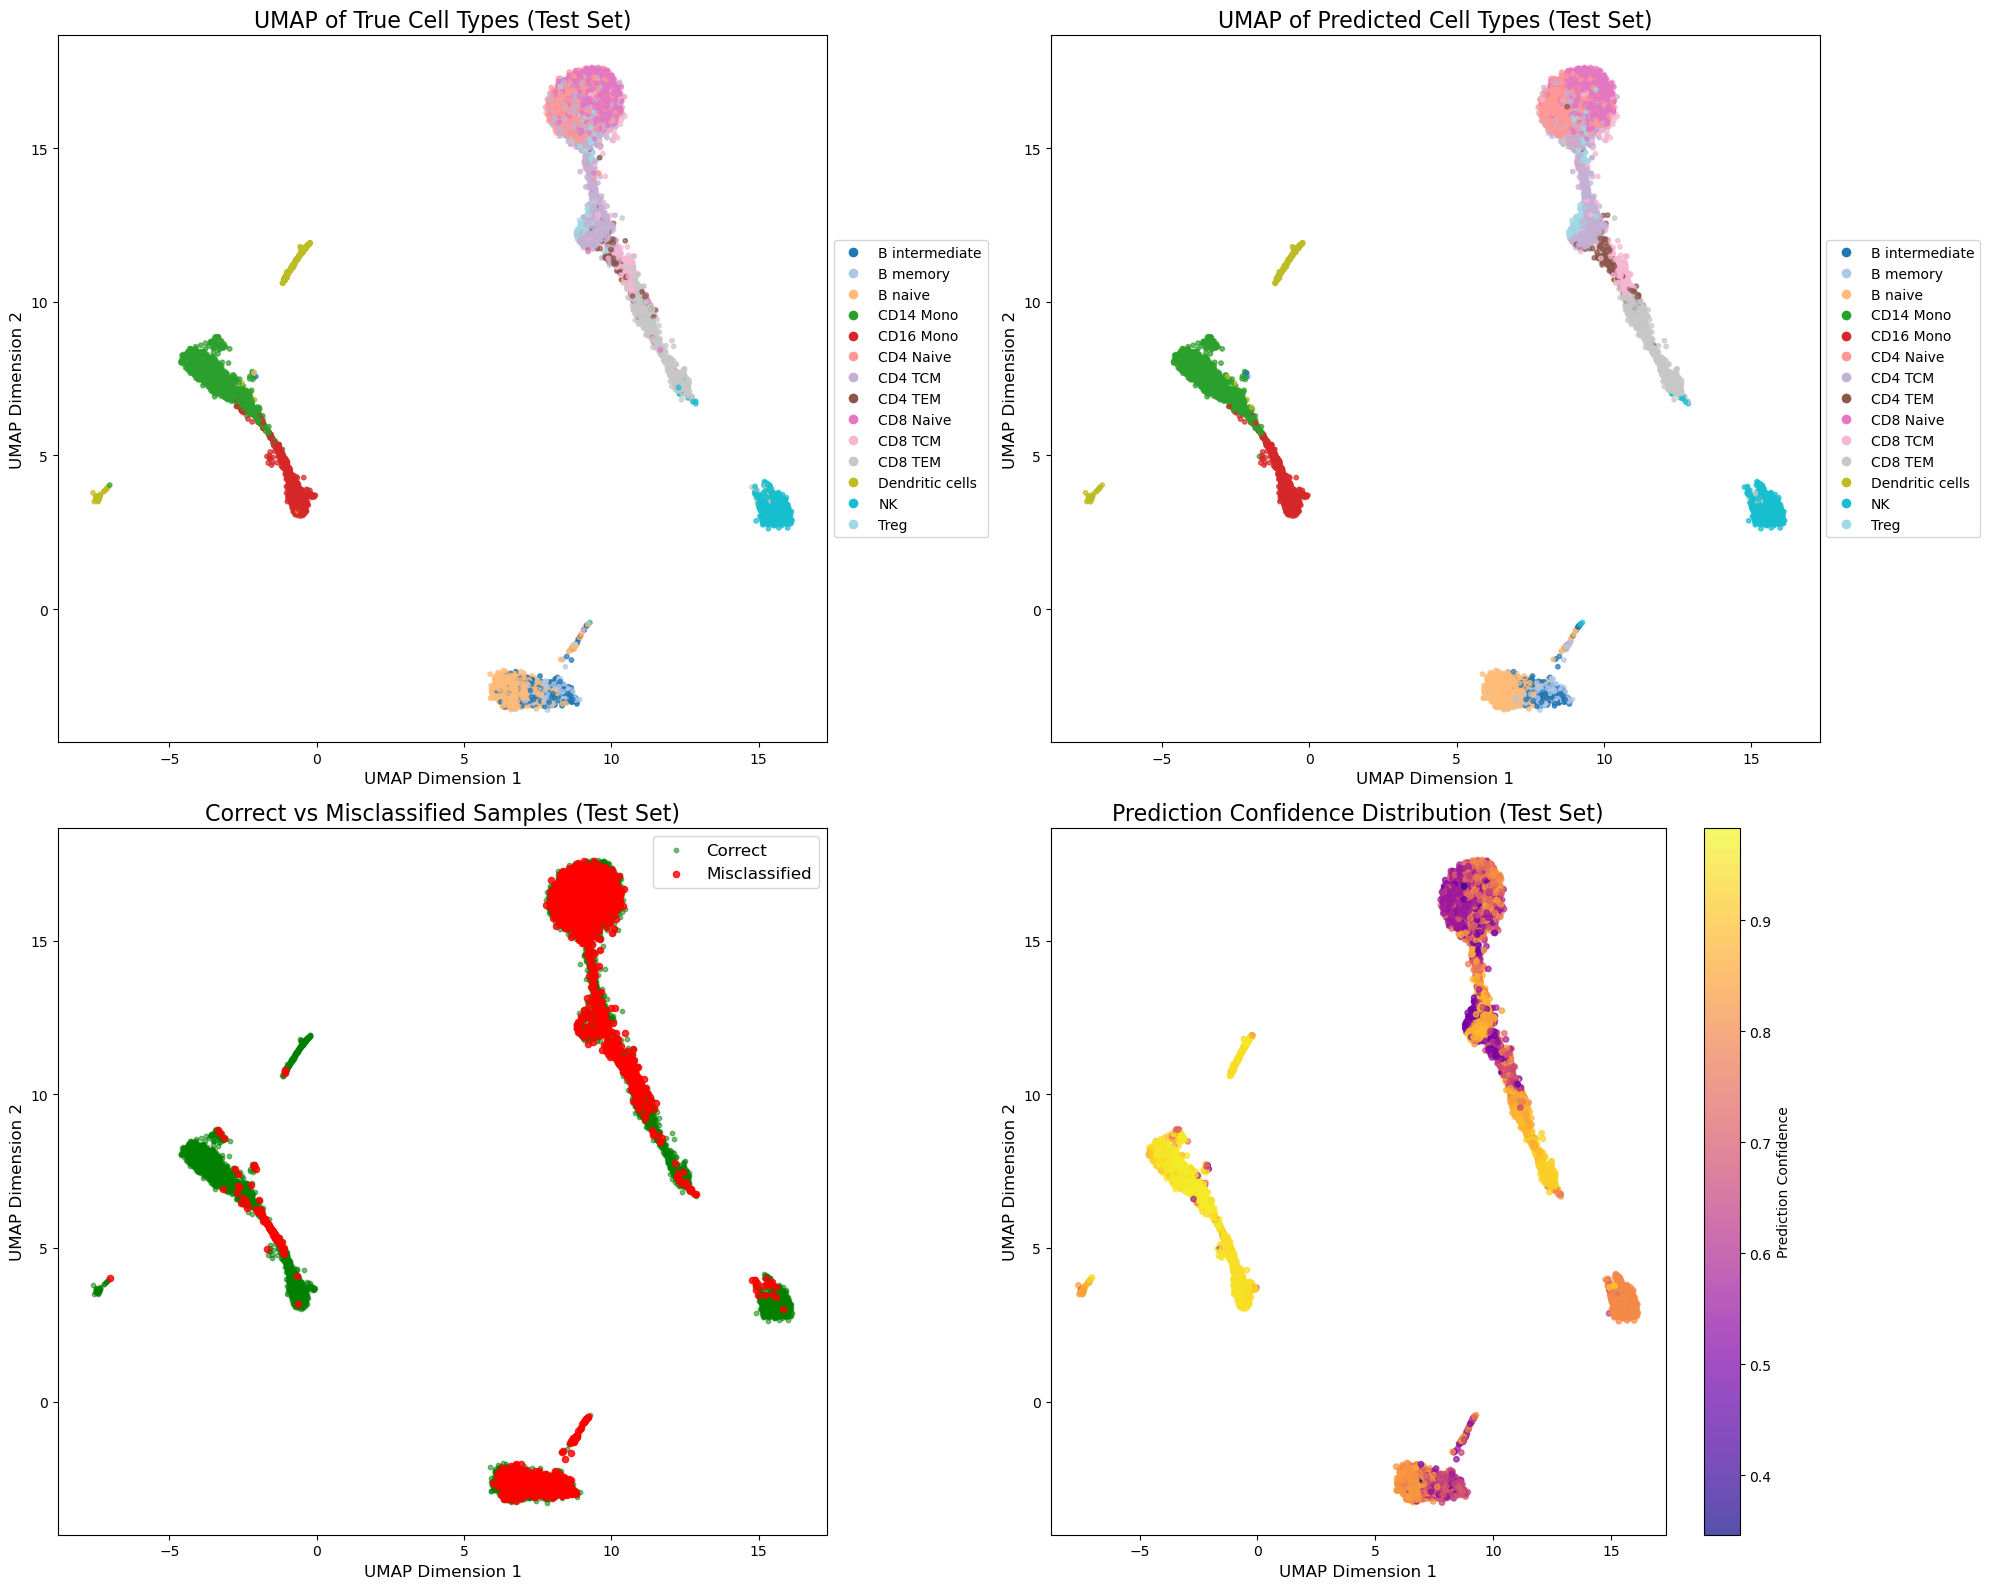


Test Set Accuracy: 0.8334
Correctly classified: 9613 out of 11534 samples (83.34%)
Misclassified: 1921 out of 11534 samples (16.66%)

Top Misclassification Patterns in Test Set:
True Cell Type       Predicted As         Count      % of True Class     
----------------------------------------------------------------------
CD4 TCM              CD4 Naive            282           20.32%
CD8 Naive            CD4 Naive            166           12.20%
CD4 Naive            CD8 Naive            147           13.78%
B intermediate       B memory             107           20.50%
B intermediate       B naive              101           19.35%
B naive              B intermediate       87             7.58%
B memory             B intermediate       84            25.53%
CD4 TCM              CD8 Naive            78             5.62%
CD8 TEM              CD8 TCM              78             6.02%
CD4 TCM              Treg                 67             4.83%


In [19]:
def visualize_test_with_umap(X_test, y_test, best_model, label_encoder, inverse_mapping):
    """
    Create UMAP visualizations of the test set with predicted classes.
    
    Parameters:
    -----------
    X_test : Test features
    y_test : Test labels
    best_model : The trained SVM model
    label_encoder : Label encoder used for the dataset
    inverse_mapping : Mapping from integer labels to original labels
    """
    print("\n" + "="*80)
    print("TEST SET UMAP VISUALIZATION")
    print("="*80)
    
    # Convert data to numpy arrays if needed
    X_test_np = cp.asnumpy(X_test) if isinstance(X_test, cp.ndarray) else np.asarray(X_test)
    y_test_np = cp.asnumpy(y_test) if isinstance(y_test, cp.ndarray) else np.asarray(y_test)
    
    # Get predictions
    X_test_gpu = cp.asarray(X_test) if not isinstance(X_test, cp.ndarray) else X_test
    y_test_pred_gpu = best_model.predict(X_test_gpu)
    y_test_pred = cp.asnumpy(y_test_pred_gpu) if isinstance(y_test_pred_gpu, cp.ndarray) else y_test_pred_gpu
    
    print("\nFitting UMAP projection for test data...")
    # Create a UMAP projection
    reducer = umap.UMAP(
        n_neighbors=15,
        min_dist=0.1,
        n_components=2,
        metric='euclidean',
        random_state=RAND_SEED
    )
    
    # Fit and transform the data
    umap_embedding = reducer.fit_transform(X_test_np)
    
    # Calculate misclassification information
    misclassified = (y_test_np != y_test_pred)
    correct = ~misclassified
    
    # Get class names
    class_names = label_encoder.classes_
    
    # Create a figure with multiple subplots
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    
    # Plot 1: True cell types
    ax = axes[0, 0]
    scatter = ax.scatter(umap_embedding[:, 0], umap_embedding[:, 1], 
                         c=y_test_np, cmap='tab20', s=10, alpha=0.7)
    
    # Create a custom legend
    unique_classes = np.unique(y_test_np)
    legend_elements = []
    for cls in unique_classes:
        orig_cls = inverse_mapping.get(cls, cls)
        if orig_cls < len(class_names):
            class_name = class_names[orig_cls]
        else:
            class_name = f"Class {cls}"
        color = scatter.cmap(scatter.norm(cls))
        legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', 
                                        markerfacecolor=color, markersize=8, label=class_name))
    
    # Place legend outside the plot
    ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
    ax.set_title('UMAP of True Cell Types (Test Set)', fontsize=16)
    ax.set_xlabel('UMAP Dimension 1', fontsize=12)
    ax.set_ylabel('UMAP Dimension 2', fontsize=12)
    
    # Plot 2: Predicted cell types
    ax = axes[0, 1]
    scatter = ax.scatter(umap_embedding[:, 0], umap_embedding[:, 1], 
                         c=y_test_pred, cmap='tab20', s=10, alpha=0.7)
    
    # Create a custom legend
    unique_pred_classes = np.unique(y_test_pred)
    legend_elements = []
    for cls in unique_pred_classes:
        orig_cls = inverse_mapping.get(cls, cls)
        if orig_cls < len(class_names):
            class_name = class_names[orig_cls]
        else:
            class_name = f"Class {cls}"
        color = scatter.cmap(scatter.norm(cls))
        legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', 
                                        markerfacecolor=color, markersize=8, label=class_name))
    
    # Place legend outside the plot
    ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
    ax.set_title('UMAP of Predicted Cell Types (Test Set)', fontsize=16)
    ax.set_xlabel('UMAP Dimension 1', fontsize=12)
    ax.set_ylabel('UMAP Dimension 2', fontsize=12)
    
    # Plot 3: Correct and misclassified samples
    ax = axes[1, 0]
    ax.scatter(umap_embedding[correct, 0], umap_embedding[correct, 1], 
              c='green', label='Correct', s=10, alpha=0.5)
    ax.scatter(umap_embedding[misclassified, 0], umap_embedding[misclassified, 1], 
              c='red', label='Misclassified', s=20, alpha=0.8)
    ax.legend(fontsize=12)
    ax.set_title('Correct vs Misclassified Samples (Test Set)', fontsize=16)
    ax.set_xlabel('UMAP Dimension 1', fontsize=12)
    ax.set_ylabel('UMAP Dimension 2', fontsize=12)
    
    # Plot 4: Prediction confidence if available
    ax = axes[1, 1]
    
    try:
        # Get probability predictions
        y_test_proba = best_model.predict_proba(X_test_gpu)
        if isinstance(y_test_proba, cp.ndarray):
            y_test_proba = cp.asnumpy(y_test_proba)
        
        # Extract max probability (confidence) for each prediction
        confidences = np.max(y_test_proba, axis=1)
        
        # Plot confidence as color
        scatter = ax.scatter(umap_embedding[:, 0], umap_embedding[:, 1], 
                           c=confidences, cmap='plasma', s=15, alpha=0.7)
        
        # Add a colorbar
        cbar = plt.colorbar(scatter, ax=ax)
        cbar.set_label('Prediction Confidence', fontsize=10)
        
        ax.set_title('Prediction Confidence Distribution (Test Set)', fontsize=16)
        
    except Exception as e:
        ax.text(0.5, 0.5, "Prediction probabilities not available", 
               horizontalalignment='center', fontsize=14)
        
    ax.set_xlabel('UMAP Dimension 1', fontsize=12)
    ax.set_ylabel('UMAP Dimension 2', fontsize=12)
    
    # Adjust layout and save
    plt.tight_layout()
    plt.savefig(os.path.join(PLOT_DIR, 'svm_test_umap_visualization.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    # Calculate accuracy and print summary
    accuracy = np.mean(y_test_np == y_test_pred)
    print(f"\nTest Set Accuracy: {accuracy:.4f}")
    print(f"Correctly classified: {np.sum(correct)} out of {len(y_test_np)} samples ({np.mean(correct)*100:.2f}%)")
    print(f"Misclassified: {np.sum(misclassified)} out of {len(y_test_np)} samples ({np.mean(misclassified)*100:.2f}%)")
    
    # If there are misclassifications, analyze the most common patterns
    if np.any(misclassified):
        print("\nTop Misclassification Patterns in Test Set:")
        confusion_patterns = {}
        
        for true_cls in unique_classes:
            for pred_cls in unique_pred_classes:
                if true_cls != pred_cls:
                    mask = (y_test_np == true_cls) & (y_test_pred == pred_cls)
                    count = np.sum(mask)
                    if count > 0:
                        true_name = class_names[inverse_mapping.get(true_cls, true_cls)] if inverse_mapping.get(true_cls, true_cls) < len(class_names) else f"Class {true_cls}"
                        pred_name = class_names[inverse_mapping.get(pred_cls, pred_cls)] if inverse_mapping.get(pred_cls, pred_cls) < len(class_names) else f"Class {pred_cls}"
                        confusion_patterns[(true_name, pred_name)] = count
        
        # Sort and display
        sorted_patterns = sorted(confusion_patterns.items(), key=lambda x: x[1], reverse=True)
        
        print(f"{'True Cell Type':<20} {'Predicted As':<20} {'Count':<10} {'% of True Class':<20}")
        print("-" * 70)
        
        for (true_name, pred_name), count in sorted_patterns[:10]:  # Show top 10
            true_cls_idx = list(class_names).index(true_name) if true_name in class_names else -1
            true_cls = np.unique(y_test_np)[true_cls_idx] if true_cls_idx >= 0 else -1
            
            if true_cls != -1:
                true_cls_count = np.sum(y_test_np == true_cls)
                percentage = count / true_cls_count * 100
                print(f"{true_name:<20} {pred_name:<20} {count:<10} {percentage:>8.2f}%")
            else:
                print(f"{true_name:<20} {pred_name:<20} {count:<10}")

# Visualize test set with UMAP
visualize_test_with_umap(X_test, y_test, best_model, label_encoder, inverse_mapping)

#### Evaluting the final model on test data
This function evaluates the final model on the test data, generating a detailed classification report, confusion matrix, and performance metrics. It provides a comprehensive overview of the model's performance on unseen data and helps identify areas for improvement.

In [23]:
def evaluate_on_test_set(best_model, X_test, y_test, label_encoder, inverse_mapping):
    """
    Evaluate the model on the test set and generate metrics.
    
    Parameters:
    -----------
    best_model : The trained SVM model
    X_test : Test features
    y_test : Test labels
    label_encoder : Label encoder used for the dataset
    inverse_mapping : Mapping from integer labels to original labels
    
    Returns:
    --------
    test_metrics : Dictionary containing test set performance metrics
    """
    print("\n" + "="*80)
    print("TEST SET EVALUATION")
    print("="*80)
    
    # Convert data to GPU if needed
    X_test_gpu = cp.asarray(X_test) if not isinstance(X_test, cp.ndarray) else X_test
    y_test_np = cp.asnumpy(y_test) if isinstance(y_test, cp.ndarray) else np.asarray(y_test)
    
    # Get predictions
    y_test_pred_gpu = best_model.predict(X_test_gpu)
    y_test_pred = cp.asnumpy(y_test_pred_gpu) if isinstance(y_test_pred_gpu, cp.ndarray) else y_test_pred_gpu
    
    # Get probabilities if available
    try:
        y_test_proba = best_model.predict_proba(X_test_gpu)
        if isinstance(y_test_proba, cp.ndarray):
            y_test_proba = cp.asnumpy(y_test_proba)
        probas_available = True
    except:
        probas_available = False
    
    # Calculate performance metrics
    accuracy = accuracy_score(y_test_np, y_test_pred)
    balanced_acc = balanced_accuracy_score(y_test_np, y_test_pred)
    f1_macro = f1_score(y_test_np, y_test_pred, average='macro')
    f1_weighted = f1_score(y_test_np, y_test_pred, average='weighted')
    precision_macro = precision_score(y_test_np, y_test_pred, average='macro')
    recall_macro = recall_score(y_test_np, y_test_pred, average='macro')
    
    # Print metrics
    print("\nTest Set Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Balanced Accuracy: {balanced_acc:.4f}")
    print(f"Macro F1 Score: {f1_macro:.4f}")
    print(f"Weighted F1 Score: {f1_weighted:.4f}")
    print(f"Macro Precision: {precision_macro:.4f}")
    print(f"Macro Recall: {recall_macro:.4f}")
    
    # Generate classification report
    print("\nDetailed Classification Report:")
    class_names = label_encoder.classes_
    report = classification_report(y_test_np, y_test_pred, 
                                   target_names=class_names,
                                   zero_division=0)
    print(report)
    
    # Calculate ROC-AUC if probabilities are available
    if probas_available:
        try:
            # Get unique classes
            unique_classes = np.unique(y_test_np)
            n_classes = len(unique_classes)
            
            if n_classes > 2:
                # Multi-class ROC-AUC
                y_test_bin = label_binarize(y_test_np, classes=unique_classes)
                roc_auc = roc_auc_score(y_test_bin, y_test_proba, multi_class='ovr', average='macro')
                print(f"ROC-AUC Score (One-vs-Rest): {roc_auc:.4f}")
            else:
                # Binary classification
                roc_auc = roc_auc_score(y_test_np, y_test_proba[:, 1])
                print(f"ROC-AUC Score: {roc_auc:.4f}")
        except Exception as e:
            print(f"Could not calculate ROC-AUC: {e}")
            roc_auc = 0
    else:
        roc_auc = 0
    
    # Return metrics dictionary
    test_metrics = {
        'accuracy': accuracy,
        'balanced_accuracy': balanced_acc,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'roc_auc': roc_auc,
        'y_pred': y_test_pred,
        'classification_report': report
    }
    
    return test_metrics

# Evaluate model on test set
test_metrics = evaluate_on_test_set(best_model, X_test, y_test, label_encoder, inverse_mapping)


TEST SET EVALUATION

Test Set Performance:
Accuracy: 0.8334
Balanced Accuracy: 0.7963
Macro F1 Score: 0.7826
Weighted F1 Score: 0.8342
Macro Precision: 0.7763
Macro Recall: 0.7963

Detailed Classification Report:
                 precision    recall  f1-score   support

 B intermediate       0.64      0.60      0.62       522
       B memory       0.56      0.60      0.58       329
        B naive       0.87      0.88      0.88      1148
      CD14 Mono       0.98      0.96      0.97      1451
      CD16 Mono       0.95      0.97      0.96       953
      CD4 Naive       0.64      0.78      0.70      1067
        CD4 TCM       0.84      0.62      0.71      1388
        CD4 TEM       0.55      0.69      0.61       200
      CD8 Naive       0.80      0.85      0.82      1361
        CD8 TCM       0.62      0.62      0.62       360
        CD8 TEM       0.95      0.90      0.92      1295
Dendritic cells       0.98      0.99      0.98       394
             NK       0.98      0.98      0.

#### Saving the model and report
This function saves the trained model and the classification report to disk. It provides a convenient way to store the model for future use and ensures that the results are reproducible.

In [24]:
def save_model_and_report(best_model, best_params, val_accuracy, test_metrics, metrics_dict):
    """
    Save the trained model and generate a summary report.
    
    Parameters:
    -----------
    best_model : The trained SVM model
    best_params : Best hyperparameters
    val_accuracy : Validation accuracy
    test_metrics : Test metrics dictionary
    metrics_dict : Validation metrics dictionary
    """
    print("\n" + "="*80)
    print("MODEL SAVING AND FINAL REPORT")
    print("="*80)
    
    # Save the model
    model_filename = os.path.join(MODEL_DIR, 'svm_best_model.pkl')
    try:
        # Convert model to CPU before saving if it's on GPU
        if hasattr(best_model, 'to_cpu'):
            cpu_model = best_model.to_cpu()
            joblib.dump(cpu_model, model_filename)
        else:
            joblib.dump(best_model, model_filename)
        
        print(f"Model successfully saved to {model_filename}")
    except Exception as e:
        print(f"Error saving model: {e}")
        # Try alternative saving approach
        try:
            import pickle
            with open(model_filename.replace('.pkl', '.pickle'), 'wb') as f:
                pickle.dump(best_model, f)
            print(f"Model saved using pickle to {model_filename.replace('.pkl', '.pickle')}")
        except Exception as e2:
            print(f"Failed to save model with alternative method as well: {e2}")
    
    # Save the results and hyperparameters
    results = {
        'best_parameters': best_params,
        'validation_accuracy': val_accuracy,
        'validation_balanced_accuracy': metrics_dict.get('balanced_accuracy', 0),
        'validation_f1_macro': metrics_dict.get('f1_macro', 0),
        'test_accuracy': test_metrics.get('accuracy', 0),
        'test_balanced_accuracy': test_metrics.get('balanced_accuracy', 0),
        'test_f1_macro': test_metrics.get('f1_macro', 0),
        'test_f1_weighted': test_metrics.get('f1_weighted', 0),
        'timestamp': time.strftime("%Y-%m-%d %H:%M:%S")
    }
    
    # Save as JSON
    results_filename = os.path.join(RESULTS_DIR, 'svm_model_results.json')
    with open(results_filename, 'w') as f:
        # Convert numpy values to Python native types
        def convert_to_native(obj):
            if isinstance(obj, (np.int_, np.intc, np.intp, np.int8, np.int16, np.int32, np.int64, 
                                np.uint8, np.uint16, np.uint32, np.uint64)):
                return int(obj)
            elif isinstance(obj, (np.float_, np.float16, np.float32, np.float64)):
                return float(obj)
            elif isinstance(obj, np.ndarray):
                return obj.tolist()
            return obj
        
        import json
        results_json = {k: convert_to_native(v) for k, v in results.items()}
        json.dump(results_json, f, indent=4)
    
    print(f"Results successfully saved to {results_filename}")
    
    # Generate a summary report
    print("\nFINAL MODEL REPORT:")
    print("-" * 40)
    print(f"Best Parameters: {best_params}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    print(f"Validation Balanced Accuracy: {metrics_dict.get('balanced_accuracy', 0):.4f}")
    print(f"Validation Macro F1 Score: {metrics_dict.get('f1_macro', 0):.4f}")
    print(f"Test Accuracy: {test_metrics.get('accuracy', 0):.4f}")
    print(f"Test Balanced Accuracy: {test_metrics.get('balanced_accuracy', 0):.4f}")
    print(f"Test Macro F1 Score: {test_metrics.get('f1_macro', 0):.4f}")
    print(f"Test Weighted F1 Score: {test_metrics.get('f1_weighted', 0):.4f}")
    
    # Calculate overfitting indicators
    acc_diff = test_metrics.get('accuracy', 0) - val_accuracy
    bal_acc_diff = test_metrics.get('balanced_accuracy', 0) - metrics_dict.get('balanced_accuracy', 0)
    f1_diff = test_metrics.get('f1_macro', 0) - metrics_dict.get('f1_macro', 0)
    
    print("\nOverfitting Assessment:")
    print(f"Accuracy Shift (Validation → Test): {acc_diff:.4f} ({acc_diff/val_accuracy*100:.2f}%)")
    print(f"Balanced Accuracy Shift (Validation → Test): {bal_acc_diff:.4f} ({bal_acc_diff/metrics_dict.get('balanced_accuracy', 1)*100:.2f}%)")
    print(f"F1 Macro Shift (Validation → Test): {f1_diff:.4f} ({f1_diff/metrics_dict.get('f1_macro', 1)*100:.2f}%)")
    
    if acc_diff < -0.05 or bal_acc_diff < -0.05 or f1_diff < -0.05:
        print("Potential overfitting detected: Performance dropped notably from validation to test set.")
    elif acc_diff > 0.05 or bal_acc_diff > 0.05 or f1_diff > 0.05:
        print("Unusual pattern: Model performs notably better on test set than validation set.")
    else:
        print("✓ Model generalizes well: Similar performance on validation and test sets.")
    
    print("\nModel is ready for deployment!")

# Save model and generate final report
save_model_and_report(best_model, best_params, val_accuracy, test_metrics, metrics_dict)


MODEL SAVING AND FINAL REPORT
Model successfully saved to /mnt/f/cwd_ml/cs7641/Models/svm_best_model.pkl
Results successfully saved to /mnt/f/cwd_ml/cs7641/Results/svm_model_results.json

FINAL MODEL REPORT:
----------------------------------------
Best Parameters: {'C': 1, 'gamma': 'auto'}
Validation Accuracy: 0.8340
Validation Balanced Accuracy: 0.7998
Validation Macro F1 Score: 0.7848
Test Accuracy: 0.8334
Test Balanced Accuracy: 0.7963
Test Macro F1 Score: 0.7826
Test Weighted F1 Score: 0.8342

Overfitting Assessment:
Accuracy Shift (Validation → Test): -0.0005 (-0.06%)
Balanced Accuracy Shift (Validation → Test): -0.0035 (-0.44%)
F1 Macro Shift (Validation → Test): -0.0022 (-0.27%)
✓ Model generalizes well: Similar performance on validation and test sets.

Model is ready for deployment!


---